<a href="https://colab.research.google.com/github/bilelammouri/DFM/blob/Programs/transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data importing

In [ ]:
from google.colab import files
files.upload()
#Upload the kaggle file

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c home-credit-default-risk

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np


# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

Using only the first 1000 rows for faster run time


In [ ]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
app_train = pd.read_csv('application_train.csv.zip').sort_values('SK_ID_CURR').reset_index(drop = True)
#app_test = pd.read_csv('application_test.csv.zip').sort_values('SK_ID_CURR').reset_index(drop = True)
#bureau = pd.read_csv('bureau.csv.zip').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True)
#bureau_balance = pd.read_csv('bureau_balance.csv.zip').sort_values('SK_ID_BUREAU').reset_index(drop = True)
cash = pd.read_csv('POS_CASH_balance.csv.zip').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
credit = pd.read_csv('credit_card_balance.csv.zip').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
previous = pd.read_csv('previous_application.csv.zip').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)
#installments = pd.read_csv('installments_payments.csv.zip').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True)

# preprocessing



In [ ]:
def remove_rows(df,key,n):
  """Remove the rows of the clients that don't appear atleast n times
  Attributes :
  df: the dataframe in question
  key: the key of the data frame expl 'SK_ID_PREV'
  n : minimum nbr of instances
  """
  # make a table with 2 columns : the Key and how many times it appeared
  tbl = df.groupby(key).agg(count=   (key, 'count')).reset_index()
  #keep only those having n or more columns
  tbl=tbl[tbl['count']>=n]
  #we reset the index for an easier manipulation
  #tbl.reset_index(drop=True,inplace=True)  
  #treat the case where no key gets repeated atleast n times  
  if (tbl.empty) : 
    print('there is no row with',n+1,' instances using the key entered please reduce n')
    return None 
  l=list(tbl[key])
  tab = df[df[key].isin(l)].sort_values(by=[key])

  return tab


In [ ]:
def missingvalues (df,l1=1,l2=20) :
  """
  Takes care of the missing values in a dataframe using the following law:
  missing value ratio of each variable < 1% : delete the variable
  if the number of nan values in ]1,20] : make imputation with the mean
   missing value ratio >20% : delete the feature

  PARAMETERS :
  df : the dataframe


  """
  a = df.isnull().sum()/len(df)*100
  variables = df.columns
  for i in range(df.columns.shape[0]):
    if a[i]!=0 :
      if a[i]<l1 :
        l=[np.NaN]
        indexNames=df[df[variables[i]].isin(l)].index
        df.drop(indexNames , inplace=True)
      elif a[i]>l2 :
        df = df.drop(variables[i], 1)
      else :
        mean = df[variables[i]].mean()
        df[variables[i]].fillna(mean, inplace=True)
  return df

  

In [ ]:
import re

def replace_day_outliers(df):
    """Replace 365243 with np.nan in any columns with DAYS"""

    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})
            
    
    return df

In [ ]:

# get the days from the database
#trasnforming it into a date type 
#start date=application date

def convert_to_months(df,time_column,df_name,start_date):
  

  """  Convert the row containing the timedeltas of months to a date type
  starting from start_date and drop the old offsets:
  df: the dataframe in question
  time_column: the time_column  of the data frame that has the timeofssets expl :BALANCE
  DATE
  dfname : name of the df so that we could name the new time variable
  """

  y=pd.Timestamp(start_date)
  newname='%s_%s' % (df_name,'balance_date')
  df[newname] = df.apply(lambda x: y + pd.offsets.MonthBegin(x[time_column]), axis=1)
  df=df.drop(columns=time_column)



  return df

In [ ]:
#apply the preprocess on the credit table
credit = replace_day_outliers(credit)
credit_low= missingvalues(credit)
credit_low= remove_rows(credit_low,'SK_ID_PREV',25)

In [ ]:
#aplly the preprocessing on the cash table
cash = replace_day_outliers(cash)
cash_low= missingvalues(cash)
cash_low= remove_rows(cash_low,'SK_ID_PREV',25)

In [ ]:
#convert the time deltas to date variables on the cash table
cash_low =convert_to_months(cash_low,'MONTHS_BALANCE','cash','02-02-2016')

In [ ]:
#convert the time deltas to date variables on the credit table
credit_low=convert_to_months(credit_low,'MONTHS_BALANCE','credit','02-02-2016')

In [ ]:
credit_low

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,credit_balance_date
445,1060558,100048,1865.880,225000,0.0,0.0,0.0,0.0,7245.765,148500.00,148500.00,0.000,0.000,0.000,0.0,0,0.0,0.0,15.0,Active,0,0,2014-12-01
415,1060558,100048,27302.400,225000,27000.0,27000.0,0.0,0.0,0.000,1458.27,1458.27,25541.730,25956.900,25956.900,1.0,1,0.0,0.0,17.0,Active,0,0,2016-01-01
416,1060558,100048,146181.015,225000,0.0,0.0,0.0,0.0,8012.610,9000.00,9000.00,142251.795,147500.730,147500.730,0.0,0,0.0,0.0,12.0,Active,0,0,2014-09-01
417,1060558,100048,0.000,225000,0.0,0.0,0.0,0.0,0.000,1458.27,1458.27,0.000,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0,2015-06-01
418,1060558,100048,0.000,225000,0.0,0.0,0.0,0.0,0.000,1458.27,1458.27,0.000,0.000,0.000,0.0,0,0.0,0.0,17.0,Active,0,0,2015-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,2833536,100067,14195.745,45000,0.0,0.0,0.0,0.0,2250.000,4275.00,4275.00,13216.320,14195.745,14195.745,0.0,0,0.0,0.0,36.0,Active,0,0,2012-01-01
516,2833536,100067,33084.090,45000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.00,31816.575,33084.090,33084.090,0.0,0,0.0,0.0,28.0,Active,0,0,2011-05-01
515,2833536,100067,47478.645,45000,3600.0,3600.0,0.0,0.0,2250.000,2250.00,2250.00,44566.380,47478.645,47478.645,1.0,1,0.0,0.0,15.0,Active,0,0,2010-04-01
523,2833536,100067,38495.295,45000,0.0,21105.0,0.0,21105.0,2250.000,8775.00,8775.00,37290.915,38495.295,38495.295,0.0,2,0.0,2.0,42.0,Active,0,0,2014-03-01


In [ ]:
cash_low

,SK_ID_PREV,SK_ID_CURR,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,cash_balance_date
4388608,1000090,256713,30.0,28.0,Active,0,0,2013-10-01
4388620,1000090,256713,30.0,15.0,Active,0,0,2014-11-01
4388621,1000090,256713,30.0,21.0,Active,0,0,2014-05-01
4388622,1000090,256713,30.0,14.0,Active,0,0,2014-12-01
4388623,1000090,256713,30.0,25.0,Active,0,0,2014-01-01
...,...,...,...,...,...,...,...,...
8083721,2843489,387308,24.0,1.0,Active,0,0,2015-09-01
8083722,2843489,387308,24.0,3.0,Active,0,0,2015-07-01
8083723,2843489,387308,24.0,2.0,Active,0,0,2015-08-01
8083711,2843489,387308,24.0,18.0,Active,0,0,2014-04-01





# Stationnarity

In [ ]:
from pandas.api.types import is_numeric_dtype
from statsmodels.tsa.stattools import adfuller
def stationarity(df,time_column,key,other_keys=[],maxdf=2): 
  """
  Test the stationarity of each univariative time series in the dataframe using 
  the date column and each numerical variable using the adf test and differentiating
  until it becomes stationary or we reach the maximum number of differentiation

  PARAMS:
  df: the dataframe
  time_column:the name of the time column 
  key: the key of the dataframe 
  maxdf: maximum number of differentiation
  other_keys: the list containing other keys in our example otherkeys=['SK_ID_CURR']





  """ 
  numeric_df= df.select_dtypes('number').copy()
  not_numeric_columns=[i for i in df.columns if i not in numeric_df.columns and i!=time_column]
  #remove the identity columns
  other_keys.append(key)
  the_columns=[co for co in numeric_df.columns if co not in other_keys]
  df1 = pd.DataFrame(columns=df.columns,index=df.index)
  for i in other_keys :
    df1[i]=df[i]
  df1[time_column]=df[time_column]
  l=df.drop_duplicates( subset=key,keep="first")[key]
  for col in the_columns:
    l=[]
    for i in l :
      df2=df[df[key]==i]
      df2=df2.set_index(time_column)
      df2=df2.loc[:,col:col]
      df2=df2.sort_index(inplace=True)
      k=0
      while (adfuller(df1.iloc[:,0].values)[1]>0.05) and (k<maxdf):
        df3=df2.diff(periods=1)
        #df1=df1[1:]
        k=k+1
      if k>0:
        l.extend(df3[col].tolist())
      else :
        l.extend(df2[col].tolist())
    df1[col]=l  
  for i in not_numeric_columns :
    df1[i]=df[i]
  return df1



In [ ]:
from pandas.api.types import is_numeric_dtype
from statsmodels.tsa.stattools import adfuller
def stationarity(df,time_column,key,other_keys=[],maxdf=2): 
  """
  Test the stationarity of each univariative time series in the dataframe using 
  the date column and each numerical variable using the adf test and differentiating
  until it becomes stationary or we reach the maximum number of differentiation

  PARAMS:
  df: the dataframe
  time_column:the name of the time column 
  key: the key of the dataframe 
  maxdf: maximum number of differentiation
  other_keys: the list containing other keys in our example otherkeys=['SK_ID_CURR']





  """ 
  #remove the identity columns
  other_keys.append(key)
  the_columns=[co for co in df.columns if co not in other_keys]
  
  for col in the_columns:
    if is_numeric_dtype(df[col]) :
      l=df[key].value_counts().index
      for i in l :
        df1=df[df[key]==i]
        df1=df1.set_index(time_column)
        df1=df1.loc[:,col:col]
        df1.sort_index(inplace=True)
        k=0
        while (adfuller(df1.iloc[:,0].values)[1]>0.05) and (k<maxdf):
            df1=df1.diff(periods=1)
            df1=df1[1:]
            k=k+1
        if k>0 :
          df2=df1.reset_index(drop=False)
          df2[key]=i#restore th skidprev column
          df2=df2.set_index([key,time_column],drop=False)
          df=df.set_index([key,time_column],drop=False)
          df.update(df2)
          df.reset_index(inplace=True,drop=True )

  return df



In [ ]:
from pandas.api.types import is_numeric_dtype
from statsmodels.tsa.stattools import adfuller
def stationarity(df,time_column,key,other_keys=[],maxdf=2): 
  """
  Test the stationarity of each univariative time series in the dataframe using 
  the date column and each numerical variable using the adf test and differentiating
  until it becomes stationary or we reach the maximum number of differentiation

  PARAMS:
  df: the dataframe
  time_column:the name of the time column 
  key: the key of the dataframe 
  maxdf: maximum number of differentiation
  other_keys: the list containing other keys in our example otherkeys=['SK_ID_CURR']





  """ 
  numeric_df= df.select_dtypes('number').copy()

  #remove the identity columns
  other_keys.append(key)
  the_columns=[co for co in numeric_df.columns if co not in other_keys]
  l=df[key].value_counts().index

  for col in the_columns:
    for i in l :
      df1=df[df[key]==i]
      df1=df1.set_index(time_column)
      df1=df1.loc[:,col:col]
      df1.sort_index(inplace=True)
      k=0
      while (adfuller(df1.iloc[:,0].values)[1]>0.05) and (k<maxdf):
        df1=df1.diff(periods=1)
        df1=df1[1:]
        k=k+1
      if k>0 :
        df2=df1.reset_index(drop=False)
        df2[key]=i#restore th skidprev column
        df2=df2.set_index([key,time_column],drop=False)
        df=df.set_index([key,time_column],drop=False)
        df.update(df2)
        df.reset_index(inplace=True,drop=True )

  return df



In [ ]:
s=stationarity(cash_lower,'cash_balance_date','SK_ID_PREV',['SK_ID_CURR'])
s

In [ ]:
s1=stationarity(credit_low,'credit_balance_date','SK_ID_PREV',['SK_ID_CURR'])
s1

,SK_ID_PREV,SK_ID_CURR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,credit_balance_date
0,1060558.0,100048,-131858.955,225000.0,0.0,0.0,0.0,0.0,-209.475,148500.00,148500.00,-130204.485,-134960.715,-134960.715,0.0,0.0,0.0,0.0,1.0,Active,0.0,0.0,2014-12-01
1,1060558.0,100048,27302.400,225000.0,27000.0,27000.0,0.0,0.0,0.000,1458.27,1458.27,25541.730,25956.900,25956.900,1.0,1.0,0.0,0.0,0.0,Active,0.0,0.0,2016-01-01
2,1060558.0,100048,-3160.350,225000.0,0.0,0.0,0.0,0.0,-159.660,9000.00,9000.00,-3194.010,-3182.895,-3182.895,0.0,0.0,0.0,0.0,1.0,Active,0.0,0.0,2014-09-01
3,1060558.0,100048,0.000,225000.0,0.0,0.0,0.0,0.0,0.000,1458.27,1458.27,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,Active,0.0,0.0,2015-06-01
4,1060558.0,100048,0.000,225000.0,0.0,0.0,0.0,0.0,0.000,1458.27,1458.27,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,Active,0.0,0.0,2015-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,2833536.0,100067,-3295.575,45000.0,0.0,0.0,0.0,0.0,0.000,4275.00,4275.00,-3257.055,-3295.575,-3295.575,0.0,0.0,0.0,0.0,1.0,Active,0.0,0.0,2012-01-01
871,2833536.0,100067,-982.485,45000.0,0.0,0.0,0.0,0.0,0.000,2250.00,2250.00,-967.365,-982.485,-982.485,0.0,0.0,0.0,0.0,1.0,Active,0.0,0.0,2011-05-01
872,2833536.0,100067,3907.800,45000.0,3600.0,3600.0,0.0,0.0,0.000,2250.00,2250.00,3600.000,3907.800,3907.800,1.0,1.0,0.0,0.0,1.0,Active,0.0,0.0,2010-04-01
873,2833536.0,100067,13534.380,45000.0,0.0,21105.0,0.0,1129.5,0.000,8775.00,8775.00,13433.760,13534.380,13534.380,0.0,0.0,0.0,0.0,1.0,Active,0.0,0.0,2014-03-01


# Encoding

In [ ]:
pip install category_encoders


In [ ]:

def dummyencoding (df,l):
  """ 
  Makes the dummy encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for col in l:
    df1=pd.get_dummies(data=df[col],drop_first=False)
    df = df.drop(columns =[col])
    df=pd.concat([df, df1],axis = 1)

  return df

In [ ]:
dummyencoding(credit,['NAME_CONTRACT_STATUS'])


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,Active,Approved,Completed,Demand,Refused,Sent proposal,Signed
0,1489396,100006,-2,0.000,270000,5961.324822,0.0,288.169582,2968.804848,0.000,10280.537702,0.000,0.00,0.000,0.000,0.309449,0,0.004812,0.559479,0.0,0,0,1,0,0,0,0,0,0
1,1489396,100006,-1,0.000,270000,5961.324822,0.0,288.169582,2968.804848,0.000,10280.537702,0.000,0.00,0.000,0.000,0.309449,0,0.004812,0.559479,0.0,0,0,1,0,0,0,0,0,0
2,1489396,100006,-5,0.000,270000,5961.324822,0.0,288.169582,2968.804848,0.000,10280.537702,0.000,0.00,0.000,0.000,0.309449,0,0.004812,0.559479,0.0,0,0,1,0,0,0,0,0,0
3,1489396,100006,-3,0.000,270000,5961.324822,0.0,288.169582,2968.804848,0.000,10280.537702,0.000,0.00,0.000,0.000,0.309449,0,0.004812,0.559479,0.0,0,0,1,0,0,0,0,0,0
4,1489396,100006,-4,0.000,270000,5961.324822,0.0,288.169582,2968.804848,0.000,10280.537702,0.000,0.00,0.000,0.000,0.309449,0,0.004812,0.559479,0.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1794451,456250,-7,174435.885,180000,0.000000,0.0,0.000000,0.000000,9240.705,9675.000000,590.625,172012.32,174435.885,174435.885,0.000000,0,0.000000,0.000000,4.0,0,0,1,0,0,0,0,0,0
3840308,1794451,456250,-8,177219.000,180000,0.000000,0.0,0.000000,0.000000,9465.705,9675.000000,434.295,174653.82,176958.900,176958.900,0.000000,0,0.000000,0.000000,3.0,0,0,1,0,0,0,0,0,0
3840309,1794451,456250,-12,181993.500,180000,171000.000000,171000.0,0.000000,0.000000,0.000,10280.537702,0.000,171000.00,171000.000,171000.000,7.000000,7,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0,0
3840310,1794451,456250,-11,200208.915,180000,9000.000000,9000.0,0.000000,0.000000,0.000,10280.537702,0.000,180000.00,196581.915,196581.915,1.000000,1,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0,0


In [ ]:
import category_encoders as ce
def effectencoding (df,l):
  """ 
  Makes the effect encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for i in range(len(l)):
    encoder=ce.sum_coding.SumEncoder(cols=l[i],verbose=True,)
    df=encoder.fit_transform(df)

  return df

In [ ]:
effectencoding(credit,['NAME_CONTRACT_STATUS'])

In [ ]:
import category_encoders as ce
def binaryencoding (df,l):
  """ 
  Makes the binary encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for i in range(len(l)):
    encoder= ce.BinaryEncoder(cols=l[i],return_df=True)
    df=encoder.fit_transform(df) 

  return df

In [ ]:
binaryencoding(credit,['NAME_CONTRACT_STATUS'])

In [ ]:
import category_encoders as ce
def basenencoding (df,l):
  """ 
  Makes the base n encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for i in range(len(l)):
    encoder= ce.BaseNEncoder(cols=l[i],return_df=True,base=5)
    df=encoder.fit_transform(df) 

  return df

In [ ]:
basenencoding(credit,['NAME_CONTRACT_STATUS'])

In [ ]:
import category_encoders as ce
def hashencoding (df,l,k):
  """ 
  Makes the hash encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  k : number of components in hash encoding
  """
  for i in range(len(l)):
    encoder=ce.HashingEncoder(cols=l[i],n_components=k)
    df=encoder.fit_transform(df) 

  return df

In [ ]:
hashencoding(credit,['NAME_CONTRACT_STATUS'],1)

In [ ]:
import category_encoders as ce
def targetencoding (df,l,target):
  """ 
  Makes the target encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  target : the main variable that you are going to perdict
  """
  for col in l:
    encoder=ce.TargetEncoder(cols=col) 
    df1=encoder.fit_transform(df[col],df[target]) 
    df = df.drop(columns =[col])
    df=pd.concat([df, df1],axis = 1)

  return df

In [ ]:
targetencoding(credit,['NAME_CONTRACT_STATUS'],'CNT_INSTALMENT_MATURE_CUM')

In [ ]:
import category_encoders as ce
def labelencoding (df,l):
  """ 
  Makes the label encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for col in l:
    encoder= ce.OrdinalEncoder(cols=col,return_df=True,)
    df=encoder.fit_transform(df) 
  return df

In [ ]:
labelencoding(credit,['NAME_CONTRACT_STATUS'])

In [ ]:
import category_encoders as ce
def onehotencoding (df,l):
  """ 
  Makes the one hot encoding
  --------
  PARAMS :
  df : the datframe 
  l : list of columns that need enconding
  """
  for col in l:
    encoder=ce.OneHotEncoder(cols=col,handle_unknown='return_nan',return_df=True,use_cat_names=True)
    df=encoder.fit_transform(df) 
  return df

In [ ]:
onehotencoding(credit,['NAME_CONTRACT_STATUS'])

In [ ]:
pip install scorecardpy

     |████████████████████████████████| 55 kB 2.6 MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57845 sha256=a020faaf89d45460e4e8066a66aec10d910fb9a23ee738de1c379f410ae9e0ab
  Stored in directory: /root/.cache/pip/wheels/9d/50/52/715367c478fd2e2317070ccf6539b2c29fc8168144cfbfaeac
Successfully built scorecardpy


In [ ]:
import scorecardpy as sc


In [ ]:
def woe(df,target, breakpoint={}):
  """ 
  Makes the weight of evidence encoding
  --------
  PARAMS :
  df : the datframe 
  target : target column
  breakpoint : a dictionary where we specify breaks manually
  --------
  
  """
  # woe binning 
  bins = sc.woebin(df, y=target, breaks_list=breakpoint)
  # converting the dataframe into woe values
  df = sc.woebin_ply(df, bins)
  return df





In [ ]:
train=woe(app_train,'TARGET')

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 304531 rows and 71 columns in 00:01:37
[INFO] converting into woe values ...
Woe transformating on 304531 rows and 70 columns in 00:01:02


In [ ]:
train

,TARGET,FLAG_MOBIL,FLAG_DOCUMENT_5_woe,FLAG_DOCUMENT_6_woe,AMT_INCOME_TOTAL_woe,FLAG_DOCUMENT_13_woe,AMT_REQ_CREDIT_BUREAU_HOUR_woe,REG_REGION_NOT_LIVE_REGION_woe,FLAG_EMP_PHONE_woe,NAME_INCOME_TYPE_woe,REGION_RATING_CLIENT_W_CITY_woe,DAYS_BIRTH_woe,FLAG_PHONE_woe,REGION_RATING_CLIENT_woe,FLAG_DOCUMENT_2_woe,FLAG_DOCUMENT_14_woe,DEF_30_CNT_SOCIAL_CIRCLE_woe,NAME_EDUCATION_TYPE_woe,FLAG_DOCUMENT_21_woe,EXT_SOURCE_2_woe,REG_CITY_NOT_LIVE_CITY_woe,FLAG_DOCUMENT_11_woe,FLAG_DOCUMENT_17_woe,FLAG_OWN_CAR_woe,AMT_CREDIT_woe,AMT_GOODS_PRICE_woe,OBS_60_CNT_SOCIAL_CIRCLE_woe,AMT_REQ_CREDIT_BUREAU_QRT_woe,FLAG_DOCUMENT_19_woe,FLAG_DOCUMENT_7_woe,CNT_FAM_MEMBERS_woe,FLAG_DOCUMENT_4_woe,OBS_30_CNT_SOCIAL_CIRCLE_woe,AMT_REQ_CREDIT_BUREAU_WEEK_woe,REGION_POPULATION_RELATIVE_woe,DEF_60_CNT_SOCIAL_CIRCLE_woe,FLAG_CONT_MOBILE_woe,FLAG_DOCUMENT_20_woe,NAME_TYPE_SUITE_woe,FLAG_EMAIL_woe,AMT_REQ_CREDIT_BUREAU_YEAR_woe,FLAG_DOCUMENT_15_woe,AMT_ANNUITY_woe,FLAG_DOCUMENT_8_woe,EXT_SOURCE_3_woe,REG_REGION_NOT_WORK_REGION_woe,AMT_REQ_CREDIT_BUREAU_DAY_woe,CODE_GENDER_woe,DAYS_REGISTRATION_woe,REG_CITY_NOT_WORK_CITY_woe,DAYS_LAST_PHONE_CHANGE_woe,CNT_CHILDREN_woe,FLAG_DOCUMENT_3_woe,LIVE_CITY_NOT_WORK_CITY_woe,FLAG_DOCUMENT_12_woe,WEEKDAY_APPR_PROCESS_START_woe,NAME_FAMILY_STATUS_woe,SK_ID_CURR_woe,HOUR_APPR_PROCESS_START_woe,FLAG_WORK_PHONE_woe,FLAG_DOCUMENT_9_woe,DAYS_EMPLOYED_woe,FLAG_DOCUMENT_10_woe,FLAG_DOCUMENT_18_woe,FLAG_DOCUMENT_16_woe,NAME_HOUSING_TYPE_woe,ORGANIZATION_TYPE_woe,NAME_CONTRACT_TYPE_woe,DAYS_ID_PUBLISH_woe,AMT_REQ_CREDIT_BUREAU_MON_woe,FLAG_OWN_REALTY_woe,LIVE_REGION_NOT_WORK_REGION_woe
0,1,1,0.0,0.032371,0.045106,0.0,-0.048661,0.0,0.076898,0.189279,-0.021761,0.376153,-0.148930,-0.025725,0.0,0.0,0.286915,0.112115,0.0,0.402053,-0.048732,0.0,0.0,0.056057,0.250320,0.279569,0.020772,-0.030327,0.0,0.0,0.040612,0.0,0.021135,-0.048842,0.055430,0.323301,0.0,0.0,0.013224,0.001500,0.029619,0.0,0.120132,0.009166,1.104822,-0.00601,-0.049841,0.252739,0.056139,-0.107351,-0.195401,-0.049479,0.098102,-0.057180,0.0,0.009640,0.221892,-0.02967,0.001524,-0.053108,0.0,0.285265,0.0,0.0,0.0,-0.035581,0.219018,0.034341,0.098239,-0.038202,-0.016484,0.0
1,0,1,0.0,0.032371,-0.145588,0.0,-0.048661,0.0,0.076898,-0.365753,-0.543622,-0.096080,-0.148930,-0.548070,0.0,0.0,-0.042699,-0.439496,0.0,-0.458350,-0.048732,0.0,0.0,0.056057,-0.223571,-0.373123,-0.022738,-0.030327,0.0,0.0,-0.068423,0.0,-0.022897,-0.048842,0.087023,-0.034486,0.0,0.0,-0.083251,0.001500,-0.130299,0.0,0.120132,0.009166,-0.048795,-0.00601,-0.049841,-0.155634,0.056139,-0.107351,0.147037,-0.049479,0.098102,-0.057180,0.0,-0.044189,-0.071863,-0.02967,0.001524,-0.053108,0.0,0.285265,0.0,0.0,0.0,-0.035581,-0.432129,0.034341,0.221161,-0.038202,0.036730,0.0
2,0,1,0.0,0.032371,0.045106,0.0,-0.048661,0.0,0.076898,0.189279,-0.021761,-0.096080,-0.148930,-0.025725,0.0,0.0,-0.042699,0.112115,0.0,-0.039569,-0.048732,0.0,0.0,-0.116847,-0.321536,-0.221035,-0.022738,-0.030327,0.0,0.0,0.040612,0.0,-0.022897,-0.048842,0.055430,-0.034486,0.0,0.0,0.013224,0.001500,-0.130299,0.0,-0.150015,0.009166,-0.775838,-0.00601,-0.049841,0.252739,0.056139,-0.107351,0.147037,-0.049479,-0.285905,-0.057180,0.0,-0.044189,0.221892,-0.02967,0.001524,0.192007,0.0,0.285265,0.0,0.0,0.0,-0.035581,-0.183724,-0.409165,0.098239,-0.038202,-0.016484,0.0
3,0,1,0.0,0.032371,0.045106,0.0,0.261863,0.0,0.076898,0.189279,-0.021761,-0.096080,0.053551,-0.025725,0.0,0.0,-0.042699,0.112115,0.0,-0.458350,-0.048732,0.0,0.0,0.056057,0.250320,0.045459,0.020772,0.271305,0.0,0.0,-0.068423,0.0,0.021135,0.223884,0.087023,-0.034486,0.0,0.0,0.013224,0.001500,0.029619,0.0,0.120132,0.009166,-0.048795,-0.00601,0.268305,-0.155634,-0.383891,-0.107351,0.147037,-0.049479,0.098102,-0.057180,0.0,0.009640,0.221892,-0.02967,-0.192587,-0.053108,0.0,-0.283143,0.0,0.0,0.0,-0.035581,0.219018,0.034341,0.098239,0.271305,-0.016484,0.0
4,0,1,0.0,0.032371,0.045106,0.0,-0.048661,0.0,0.076898,0.189279,-0.021761,-0.096080,0.053551,-0.025725,0.0,0.0,-0.042699,0.112115,0.0,0.402053,-0.0

In [ ]:
train['SK_ID_CURR_woe']=app_train['SK_ID_CURR']

# Transforming the data

  **Function** creating aggregated variables : 

In [ ]:
def agg_numeric(df, parent_var,other_keys,List_of_agg, df_name=''):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        List_of_agg (list of string):
          a list containing the name of the aggregation functions 
          L=['mean','min','max','std','median']
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable

    df1=df.drop(other_keys,axis=1)
            
    # Only want the numeric variables
    numeric_df1 = df1.select_dtypes('number').copy()

    # Group by the specified variable and calculate the statistics
    agg = numeric_df1.groupby(parent_var).agg(List_of_agg)

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
      # Iterate through the stat names
      for stat in agg.columns.levels[1]:
      # Make a new column name for the variable and stat
        columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]

    agg=agg.reset_index()
    for i in other_keys:
      agg[i]=df.drop_duplicates( subset=parent_var,keep="first").reset_index()[i]
  
    return agg

In [ ]:
df1=agg_numeric(credit_low,'SK_ID_PREV',['SK_ID_CURR'],List_of_agg=['mean','max','min','std'], df_name='credit')

In [ ]:
df1

,SK_ID_PREV,credit_AMT_RECIVABLE_min,credit_AMT_TOTAL_RECEIVABLE_min,credit_SK_DPD_min,credit_CNT_DRAWINGS_CURRENT_min,credit_AMT_DRAWINGS_CURRENT_min,credit_AMT_PAYMENT_TOTAL_CURRENT_min,credit_AMT_RECEIVABLE_PRINCIPAL_min,credit_AMT_BALANCE_min,credit_AMT_INST_MIN_REGULARITY_min,credit_CNT_DRAWINGS_OTHER_CURRENT_min,credit_CNT_DRAWINGS_ATM_CURRENT_min,credit_CNT_DRAWINGS_POS_CURRENT_min,credit_AMT_DRAWINGS_OTHER_CURRENT_min,credit_AMT_DRAWINGS_POS_CURRENT_min,credit_AMT_DRAWINGS_ATM_CURRENT_min,credit_AMT_PAYMENT_CURRENT_min,credit_AMT_CREDIT_LIMIT_ACTUAL_min,credit_SK_DPD_DEF_mean,credit_SK_DPD_mean,credit_SK_DPD_DEF_std,credit_SK_DPD_std,credit_SK_DPD_DEF_max,credit_SK_DPD_max,credit_CNT_DRAWINGS_OTHER_CURRENT_mean,credit_CNT_DRAWINGS_OTHER_CURRENT_std,credit_CNT_DRAWINGS_OTHER_CURRENT_max,credit_CNT_DRAWINGS_POS_CURRENT_mean,credit_CNT_DRAWINGS_ATM_CURRENT_mean,credit_CNT_DRAWINGS_CURRENT_mean,credit_CNT_DRAWINGS_ATM_CURRENT_std,credit_CNT_DRAWINGS_POS_CURRENT_std,credit_CNT_INSTALMENT_MATURE_CUM_min,credit_CNT_DRAWINGS_CURRENT_std,credit_CNT_DRAWINGS_POS_CURRENT_max,credit_CNT_DRAWINGS_ATM_CURRENT_max,credit_CNT_INSTALMENT_MATURE_CUM_std,credit_CNT_DRAWINGS_CURRENT_max,credit_AMT_DRAWINGS_OTHER_CURRENT_mean,credit_CNT_INSTALMENT_MATURE_CUM_mean,credit_CNT_INSTALMENT_MATURE_CUM_max,credit_AMT_DRAWINGS_OTHER_CURRENT_std,credit_AMT_DRAWINGS_OTHER_CURRENT_max,credit_AMT_DRAWINGS_POS_CURRENT_mean,credit_AMT_INST_MIN_REGULARITY_mean,credit_AMT_INST_MIN_REGULARITY_std,credit_AMT_DRAWINGS_ATM_CURRENT_mean,credit_AMT_DRAWINGS_POS_CURRENT_std,credit_AMT_DRAWINGS_CURRENT_mean,credit_AMT_PAYMENT_TOTAL_CURRENT_mean,credit_AMT_PAYMENT_CURRENT_mean,credit_AMT_INST_MIN_REGULARITY_max,credit_AMT_DRAWINGS_ATM_CURRENT_std,credit_AMT_DRAWINGS_POS_CURRENT_max,credit_AMT_DRAWINGS_CURRENT_std,credit_AMT_PAYMENT_CURRENT_std,credit_AMT_PAYMENT_TOTAL_CURRENT_std,credit_AMT_RECEIVABLE_PRINCIPAL_mean,credit_AMT_BALANCE_mean,credit_AMT_RECIVABLE_mean,credit_AMT_TOTAL_RECEIVABLE_mean,credit_AMT_RECEIVABLE_PRINCIPAL_std,credit_AMT_BALANCE_std,credit_AMT_TOTAL_RECEIVABLE_std,credit_AMT_RECIVABLE_std,credit_AMT_CREDIT_LIMIT_ACTUAL_std,credit_AMT_CREDIT_LIMIT_ACTUAL_mean,credit_AMT_DRAWINGS_ATM_CURRENT_max,credit_AMT_DRAWINGS_CURRENT_max,credit_AMT_PAYMENT_TOTAL_CURRENT_max,credit_AMT_PAYMENT_CURRENT_max,credit_AMT_RECEIVABLE_PRINCIPAL_max,credit_AMT_CREDIT_LIMIT_ACTUAL_max,credit_AMT_BALANCE_max,credit_AMT_RECIVABLE_max,credit_AMT_TOTAL_RECEIVABLE_max,SK_ID_CURR
0,1000087,0.000,0.000,0,0,0.0,0.0,0.00,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000000,0,0,0.000150,0.000851,0.004812,0.204984,0.228420,0.406250,0.658104,0.739844,1.0,1.364513,3.000000,3.0,4.169839,6,9.005299,9.895318,20.825084,50.941666,288.169582,996.249995,2323.894789,3085.529558,3561.291401,3593.861360,4278.474844,6165.232031,6486.498834,7096.860000,13187.008401,16100.145000,16439.831888,22997.460303,23014.550610,37748.400469,39078.104063,39085.408125,39085.408125,57284.939753,59186.641661,59298.831187,59298.831187,68445.992071,71718.750000,72000.0,88100.145,131175.0,131175.0,132554.835,135000,136005.750,137042.640,137042.640,399664
1,1000094,0.000,0.000,0,0,0.0,0.0,0.00,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.011364,0.011364,0.106600,0.106600,1,1,0.000109,0.000721,0.004812,0.012715,0.097942,0.090909,0.391686,0.083859,1.0,0.390589,0.559479,3.0,16.186741,3,6.549309,33.232673,48.000000,43.192804,288.169582,67.472837,2046.605425,1976.724546,1710.484655,444.984529,1575.011761,2915.807216,2955.400057,9000.000000,8175.160798,2968.804848,8152.699814,5807.151937,5818.757431,28023.718295,29363.103920,29357.869091,29386.505455,28449.300980,29722.552756,29700.357994,29727.761992,28936.757127,51392.045455,67500.0,67500.000,45720.0,45720.0,67496.085,67500,72248.805,72248.805,72248.805,359175
2,1000096,-3.960,-3.960,0,0,0.0,0.0,0.00,0.000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180000,0.000000,0.354167,0.000000,3.165535,0,31,0.000000,0.000000,0.000000,0.083333,0.177083

# AR Model

In [ ]:
! pip install pmdarima
from pmdarima.arima import auto_arima

In [ ]:
from pandas.api.types import is_numeric_dtype
def AR_feature(df,time_column,key,other_keys=[],df_name=''):
  """
  Creates a table contating the coeffcients of the estiamted Auto Regression model
  created for each time series present in the dataframe
  ________________________
  PARAMS:

  df: the dataframe containg a date column and multiple numeric columns
  time_column : containing the name of the time column 
  key: the unique key of the dataframe
  df_name: the name of the dataframe
  other_keys: the list containing other keys in our example otherkeys=['SK_ID_CURR']
  ___________________________
  RETURN 
  a dataframe that has the parameters of the AR model as columns for each key 
  """
  #Removing the columns that reperenst the identities of the rows 

  the_columns=df.columns
  other_keys.append(key)
  the_columns=[co for co in the_columns if co not in other_keys]
  
  #conserving the other keys in a variable
  conserve=[i for i in other_keys]
  #get the columns of our dataframe
  
  c=the_columns
  # go through the columns
  # Iterate through the variables names
  #columns are ar columns
  columns=other_keys

  num=[i for i in range(6) ]
  for var in the_columns:
    if is_numeric_dtype(df[var]) :
      for n in num:
        columns.append('%s_%s_%d' % (df_name,var,n))


  l=df[key].value_counts().index
  ar = pd.DataFrame(columns=columns,index=range(1, len(l)+1))
  ar[key]=df[key].value_counts().index
  #add a column to ar which contains the other keys
  #conserve contains th other_keys we remove the existing key and add the others
  conserve.remove(key)
  #add as much columns as the number of other keys
  while(len(conserve)>=1):
    lis=[]
    for element in l:
      new=df[df[key]==element][conserve[0]].iloc[0]
      lis.append(new)
    ar[conserve[0]]=lis
    conserve.remove(conserve[0])

  k=2
  for col in the_columns:
    #check if the column is numeric to extract the time series
    if is_numeric_dtype(df[col]) :
      for i in l :
        d=0
        #create the datframe containing only the occurences of 1 individual
        
        df1=df[df[key]==i]
        df1=df1.set_index(time_column)
        #select on variable
        df1=df1.loc[:,col:col]
        df1.sort_index(inplace=True)
        # get the days from the database

        arima_model=auto_arima(df1,start_p=0, d=0, start_q=0, max_p=5, max_d=0, 
                      max_q=0, start_Q=0, max_P=1, max_D=1, max_Q=2,m=12, seasonal=False,
                      error_action='warn',trace=True, supress_warnings=True,stepwise=True,
                      random_state=20,n_fits=50 )
        for j in arima_model.params():
          ar.loc[ar[key]==i,columns[k:][d]] =j
          d+=1
      k+=6  
  for col in ar.columns:
    ar[col] = ar[col].replace({np.nan: 0})
  for col in ar.columns:
    if ((ar[col] == 0).all()):
      ar = ar.drop(columns =col)

  return ar 

In [ ]:
AR_feature(cash_low,'cash_balance_date','SK_ID_PREV',['SK_ID_CURR'],)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=411.368, Time=0.01 sec
Total fit time: 0.008 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=353.186, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-40.607, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-36.126, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.158 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=291.208, Time=0.01 sec
Total fit time: 0.006 seconds
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=231.850, Time=0.01 sec
Total fit time: 0.007 seconds
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=265.108, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=258.630, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] interce

,SK_ID_CURR,SK_ID_PREV,_CNT_INSTALMENT_0,_CNT_INSTALMENT_1,_CNT_INSTALMENT_FUTURE_0,_CNT_INSTALMENT_FUTURE_1,_SK_DPD_0,_SK_DPD_1,_SK_DPD_DEF_0,_SK_DPD_DEF_1,_SK_DPD_DEF_2
1,100008,1907290,100.000000,0.000000,1.000000,6.000000,9.523128e-01,30683.523480,1.000000e-10,0.00000,0.000000
2,100011,1430602,11.977778,0.021728,1.733333,11.440000,9.371551e-01,20346.912472,8.332372e-01,-0.24687,2.540336
3,100011,2794143,900.000000,0.000000,14.900000,82.356667,1.000000e-10,0.000000,1.000000e-10,0.00000,0.000000
4,100016,2824473,576.000000,0.000000,12.000000,52.000000,1.000000e-10,0.000000,1.000000e-10,0.00000,0.000000


# PCA

In [ ]:
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
def pca(df,keys,time_column='',percentage_variance=0.99):
  l=[]
  for col in df.columns :
    if is_numeric_dtype(df[col]) :
      l.append(col)
  for i in keys :
    l.remove(i)
  model=PCA(n_components=len(l))
  df1=model.fit_transform(df[l])
  nc=np.argmax(np.cumsum(model.explained_variance_ratio_)>percentage_variance)+1
  model=PCA(n_components=nc)
  df1=model.fit_transform(df[l])
  columns=[]
  for i in range(1,nc+1):
    columns.append('%s_%d' % ('component',i))
  df_pca = pd.DataFrame(df1,columns=columns,index=df.index)
  for key in keys :
    df_pca[key]=df[key]
  if time_column!='' :
    df_pca[time_column]=df[time_column]
  return df_pca

In [ ]:
credit_lower_pca=pca(credit_lower,['SK_ID_CURR','SK_ID_PREV'],'credit_balance_date',percentage_variance=0.97)

In [ ]:
credit_lower_pca

,component_1,component_2,component_3,SK_ID_CURR,SK_ID_PREV,credit_balance_date
2216615,-104040.411734,92072.887838,-14115.576932,306118,1000096,2014-07-01
2216626,-104043.915668,92074.823445,-14113.031093,306118,1000096,2012-02-01
2216625,-101513.695911,92383.615818,3265.266989,306118,1000096,2010-12-01
2216624,-103987.827023,92186.686737,-12699.575168,306118,1000096,2009-06-01
2216623,-104040.411734,92072.887838,-14115.576932,306118,1000096,2014-02-01
...,...,...,...,...,...,...
317371,213480.774515,-59081.419627,-1248.779873,129613,2843263,2009-07-01
317375,-108168.871274,94377.315735,-10873.411477,129613,2843263,2012-10-01
317376,186521.375414,-44977.790114,19149.209569,129613,2843263,2010-06-01
317377,-103924.152538,92324.483903,-10984.952312,129613,2843263,2012-02-01


# var model

determining the columns to use in the var model

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=19, ncols=1, dpi=120, figsize=(20,23))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
import itertools

def VAR_feature(df,time_column,key,list_of_columns,other_keys=[],df_name='',VAR_ORDER=2):
  """
  Creates a table contating the coeffcients of the estiamted vector Auto Regression model
  created for each time series present in the dataframe
  -----------------------
  PARAMS:

  df: the dataframe containg a date column and multiple numeric columns
  time_column : containing the name of the time column 
  key: the unique key of the dataframe
  df_name: the name of the dataframe
  c:list of columns that we are uing for var model
  VAR_ORDER : the order of the var model
  ----------------------

  RETURN:
  var the dataframe that has the var model coeffecients as columns for each key
  """
  #the keys 
  other_keys.append(key)
  #the list of individuals
  
  #conserving the other keys in a variable
  conserve=[i for i in other_keys]


  
  l=df[key].value_counts().index
  #get the dataframe of each individual
  columns=other_keys
  #creating the names of the parameters of the var model
  the_indexes=[]
  for j in range(1,VAR_ORDER +1):
    for i in list_of_columns:
      the_indexes.append('%s%d_%s' % ('L',j,i))
  #creating the names of the columns of the var dataframe
  #which are a combination of the name of indexes and each variable name
  for row in the_indexes:
    for col in list_of_columns:
      columns.append('%s_%s_%s' % (df_name,row,col))
  #creating the dataframe to return
  var = pd.DataFrame(columns=columns,index=range(1, len(l)+1))
  var[key]=df[key].value_counts().index
  
  
  
  #add a column to ar which contains the other keys
  #conserve contains th other_keys we remove the existing key and add the others


  conserve.remove(key)
  #add as much columns as the number of other keys
  while(len(conserve)>=1):
    lis=[]
    for element in l:
      new=df[df[key]==element][conserve[0]].iloc[0]
      lis.append(new)
    var[conserve[0]]=lis
    conserve.remove(conserve[0])
  
  
  for i in range(len(l)) :
    
    df1=df[df[key]==l[i]]
    df1=df1.set_index(time_column)
    df1=df1[list_of_columns]
    model=VAR(df1)
    result = model.fit(VAR_ORDER,trend='nc')
    mat=result.params
    
    #list containing all values of the data frame that has the params of the var model
    lista=mat.values.tolist()
    #we got a list of list we convert it to a single list
    merged = list(itertools.chain(*lista))
    #we put the list of columns that we got into the var dataframe
    var.iloc[i,2:]=merged
    


  return var

In [ ]:
list_of_columns=['component_1','component_2','component_3'] #the chosen 1
var=VAR_feature(credit_lower_pca,'credit_balance_date','SK_ID_PREV',list_of_columns,['SK_ID_CURR'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been prov

# Feature Selection

Remove collinear variables 

The code below identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than *0.75*

In [ ]:
def remove_collinear(df,threshold=0.75):
  """
  Remove one of the collinear variables from a dataframe that have 
 
  PARAMETERS :
  ---------------------------
  df : the dataframe 
  threshold : the limit of absolute collindearity permitted 
  
  RETURNS :
  ---------------------------
  the dataframe without collinear variables above the given threeshold
  """
  corr_matrix = df.corr().abs()
  # Upper triangle of correlations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  # Select columns with correlations above threshold
  to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

  print('There are %d columns to remove.' % (len(to_drop)))
  df = df.drop(columns = to_drop)
  return df


Now we apply the 6 ways of selection

In [ ]:
X = train.drop(['SK_ID_CURR_woe', 'TARGET'], axis=1)
y = train.TARGET
feature_name = X.columns.tolist()

**1.Filter**

1.1 Pearson Correlation

In [ ]:
def cor_selector(X, y,p=50):
  """
  selects p features among all features using the pearson correlation
  
    PARAMATERS :
  ----------------

  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  
  
  p : the number of features to select

    RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if its pearson correlation with the 
  target feature is among the first p features 
  
  for example if you need the top 50 pearson correlated features with the target
  you need to set p = 50
  """
  cor_list=[]
  # calculate the correlation with y for each feature
  for i in X.columns.tolist():
      cor = np.corrcoef(X[i], y)[0, 1]
      cor_list.append(cor)
  # replace NaN with 0
  cor_list = [0 if np.isnan(i) else i for i in cor_list]
  # feature name
  cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-p:]].columns.tolist()
  # feature selection? 0 for not select, 1 for select
  cor_support = [True if i in cor_feature else False for i in feature_name]
  return cor_support

In [ ]:
cor_support = cor_selector(X, y)
cor_support

1.2 Chi2Test

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def chi_2 (X,y,p=50) :
  """
  Selects p features among all the features using the CHi2 test 
  
    PARAMATERS :
  ----------------

  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  
  
  p : the number of features to select
    
    RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if the feature and the target are 
  dependent and false otherwise, according to the chi2 test.


  """

  chi_selector = SelectKBest(chi2, p)
  X_norm = MinMaxScaler().fit_transform(X)
  chi_selector.fit(X_norm, y)
  chi_support = chi_selector.get_support()
  chi_feature = X.loc[:,chi_support].columns.tolist()
  #print(str(len(chi_feature)), 'selected features')
  return chi_support

In [ ]:
chi_support=chi_2 (X,y)
chi_support

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

**2. Wrapper**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
def rfe (X,y,estimator,p):
  """ 
  Selects p features among all the features using the RFE method
  
    PARAMATERS :
  ----------------
  estimator : the method used to estimate whether the feature is correlated with
  the target for example : estimator =LogisticRegression()
  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable or column
  
  p : the number of features to select
    
    RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if the feature and the target are 
  correlated and false otherwise, according to the RFE estimator.

  """
  rfe_selector = RFE(estimator=estimator, n_features_to_select=p)
  X_norm = MinMaxScaler().fit_transform(X)

  rfe_selector.fit(X_norm, y)
  rfe_support = rfe_selector.get_support()
  rfe_feature = X.loc[:,rfe_support].columns.tolist()
  return rfe_support

In [ ]:
rfe(X,y,LogisticRegression(),50)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True, False,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True])

**3. Embedded**

3.1 Logistic Regression

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

def lr (X,y):
  """ 
  Selects a number of features among all the features using the 
  logistic regression method 
  
  PARAMATERS :
  ----------------

  
  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  

    
  RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if the feature and the target are 
  dependent and false otherwise, according to the logistic regression method.

  """
  embeded_lr_selector =SelectFromModel( LogisticRegression())
  from sklearn.preprocessing import MinMaxScaler
  X_norm = MinMaxScaler().fit_transform(X)
  embeded_lr_selector.fit(X_norm, y)
  embeded_lr_support = embeded_lr_selector.get_support()
  embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

  return embeded_lr_support


In [ ]:
lr(X,y)

array([False,  True, False,  True,  True, False, False, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False,  True,  True])

3.2 Random Forest

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
def rf(X,y,number_estimators):

  """ 
  Selects a number of features among all the features using the 
  Random Forest aLgorithm
  
    PARAMATERS :
  ----------------

  
  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  
  
  
  number_estimators : a hyper parameter that specifies the number of estimators
  used by the random forest algorithm

    
    RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if the feature and the target are 
  dependent and false otherwise, according to the random forest algorithm.

  """
  embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=number_estimators))
  embeded_rf_selector.fit(X, y)
  embeded_rf_support = embeded_rf_selector.get_support()
  embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
  return embeded_rf_support

In [ ]:
rf(X,y,100)

array([False,  True, False, False,  True,  True, False, False, False,
       False,  True, False, False, False,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False, False, False, False,  True, False, False, False, False,
        True,  True, False,  True, False,  True,  True, False, False,
        True,  True,  True,  True,  True, False, False])

3.3 LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb


In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier
def lgb(X,y):
  """ 
  Selects a number of features among all the features using the 
  lightgbm algorithm 

    PARAMATERS :
  ----------------

  
  X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  
  

    
    RETURNS :
  ---------------
  a list containing True or False for all the features of a given dataset.
  each feature is attributed tha value True if the feature and the target are 
  dependent and false otherwise, according to the lightgbm algorithm.

  """
  lgbc=LGBMClassifier()
  embeded_lgb_selector = SelectFromModel(lgbc)
  embeded_lgb_selector.fit(X, y)
  embeded_lgb_support = embeded_lgb_selector.get_support()
  embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
  return embeded_lgb_support

In [ ]:
lgb(X,y)

array([False,  True, False, False,  True,  True, False, False, False,
       False,  True, False,  True, False,  True, False, False,  True,
        True, False,  True,  True, False,  True,  True, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False,  True, False, False,  True, False, False,
        True,  True,  True, False,  True, False, False, False, False,
        True, False, False,  True, False,  True,  True, False, False,
        True, False, False, False,  True, False,  True])

**Summary**

In [ ]:
def summary(X,y,number_estimators_rf,estimator_rfe,p=50,minimum_number=4,expert=[False for i in range(len(feature_name))]) :
  """
  function that uses all methods of feature selection and attributes to to each 
  feature the number of the total number of approved tests.

  PARAMETERS:
  ------------
   X : the train set containing all the features that might be correlated with
  the target after being preprocessed for example the train set without the ID 
  and the target after having done the encoding.
  
  y : the target variable  
  

  

  number_estimators_rf: number of estimators for random forest to use 

  estimator_rfe: the method used to estimate whether the feature is correlated with
  the target for example : estimator =LogisticRegression()
  
  p : the number of features to select for the pearson test , Chi2 test AND Rfe 
  method
  
  minimum_number : the mminimum number of tests a feature needs to pass in order 
  to be selected. For example a feature needs to be selected by 3 different tests 
  (Pearson, expert , chi2 ) 
  
  expert : a list containing True or false for each feature in the X dataset 
  giving the expert's opinion about whether the feature is useful or not, True 
  meaning it is useful and false otherwise.

  RETURNS :
  -------------- 
  Returns a dataframe containing all the selected features and the result of each 
  test and the sum of the results in the 'total' column


  """

  cor_support=cor_selector(X,y,p)
  chi_support=chi_2(X,y,p)
  rfe_support=rfe(X,y,estimator_rfe,p)
  embeded_lr_support=lr(X,y)
  embeded_rf_support=rf(X,y,number_estimators_rf)
  embeded_lgb_support=lgb(X,y)
  # put all selection together
  feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 
    'RFE':rfe_support, 'Logistics':embeded_lr_support,'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support,'Expert':expert})
  # count the selected times for each feature
  feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
  
  feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
  feature_selection_df.index = range(1, len(feature_selection_df)+1)
  return feature_selection_df[feature_selection_df['Total']>=minimum_number]

In [ ]:
feature_selection_df=summary(X,y,100,LogisticRegression(),50)
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Expert,Total
1,ORGANIZATION_TYPE_woe,True,True,True,True,True,True,False,6
2,NAME_INCOME_TYPE_woe,True,True,True,True,True,True,False,6
3,NAME_FAMILY_STATUS_woe,True,True,True,True,True,True,False,6
4,FLAG_OWN_CAR_woe,True,True,True,True,True,True,False,6
5,EXT_SOURCE_3_woe,True,True,True,True,True,True,False,6
6,EXT_SOURCE_2_woe,True,True,True,True,True,True,False,6
7,DAYS_REGISTRATION_woe,True,True,True,True,True,True,False,6
8,DAYS_LAST_PHONE_CHANGE_woe,True,True,True,True,True,True,False,6
9,DAYS_EMPLOYED_woe,True,True,True,True,True,True,False,6
10,CODE_GENDER_woe,True,True,True,True,True,True,False,6


# Modeling

Split dataset into training and test set


In [ ]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
y=train['TARGET']
X=train.drop(columns='TARGET')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(243624, 71) (60907, 71) (243624,) (60907,)


Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def Logistic_Regression (X_train, X_test, y_train) :
  """

  Applying the logistic Regression model on the train dataset to predict the 
  target

  Parameters :
  -------------
  X_train : the preprocessed dataframe containg the train data 
  X_test : the test dataset 
  y_train: the target column 

  returns : 
  ------------
  returns the probabilities for each row of the X_test 
  """

  # instantiate the model (using the default parameters)
  logreg = LogisticRegression()

  # fit the model with data
  logreg.fit(X_train,y_train)

  #prediction 
  y_pred=logreg.predict_proba(X_test)
  return y_pred


In [ ]:
y_pred1=Logistic_Regression (X_train, X_test, y_train)
y_pred1

array([[0.97800846, 0.02199154],
       [0.96478267, 0.03521733],
       [0.98239844, 0.01760156],
       ...,
       [0.90174846, 0.09825154],
       [0.9709695 , 0.0290305 ],
       [0.97420958, 0.02579042]])

Random Forest

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
def Random_Forest(X_train, X_test, y_train,n_est=100) :
  """
  
  Applying the RandomForest model on the train dataset to predict the target

  Parameters :
  -------------
  X_train : the preprocessed dataframe containg the train data 
  X_test : the test dataset 
  y_train: the target column 
  n_est: number of estimators used by the random forest
  
  returns : 
  ------------
  returns the probabilities for each row of the X_test 
  """

  #Create a Gaussian Classifier
  clf=RandomForestClassifier(n_estimators=n_est)

  #Train the model using the training sets y_pred=clf.predict(X_test)
  clf.fit(X_train,y_train)

  y_pred=clf.predict_proba(X_test)
  return y_pred 

In [ ]:
y_pred2=Random_Forest (X_train, X_test, y_train)
y_pred2

array([[0.98, 0.02],
       [0.88, 0.12],
       [0.95, 0.05],
       ...,
       [0.89, 0.11],
       [0.97, 0.03],
       [0.95, 0.05]])

xgboost

In [ ]:
# importing xgboost
from xgboost import XGBClassifier
def XGB_Classifier (X_train,y_train,X_test):
  """
  
  Applying the XGBoost model on the train dataset to predict th target

  Parameters :
  -------------
  X_train : the preprocessed dataframe containg the train data 
  X_test : the test dataset 
  y_train: the target column 

  returns : 
  ------------
  returns the probabilities for each row of the X_test 
  """

  # creating the model
  model = XGBClassifier()

  # fitting the model
  model.fit(X_train, y_train)

  # make predictions for test data
  y_pred = model.predict_proba(X_test)
  return y_pred

In [ ]:
y_pred=XGB_Classifier (X_train,y_train, X_test)
y_pred

array([[0.9560603 , 0.04393969],
       [0.90700734, 0.09299267],
       [0.9319186 , 0.06808139],
       ...,
       [0.985076  , 0.014924  ],
       [0.93134665, 0.06865332],
       [0.957023  , 0.04297697]], dtype=float32)

Lightgbm

In [ ]:
import lightgbm as lgb
def light_gbm (X_train,y_train,X_test):
  """
  
  Applying the Light gbm model on the train dataset to predict th target

  Parameters :
  -------------
  X_train : the preprocessed dataframe containg the train data 
  X_test : the test dataset 
  y_train: the target column 

  returns : 
  ------------
  returns the probabilities for each row of the X_test 
  """

  #model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', class_weight = 'balanced', learning_rate = 0.05, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.8, n_jobs = -1, random_state = 50)
  # creating the model
  clf = lgb.LGBMClassifier()
  # fitting the model
  clf.fit(X_train, y_train)
  # predict the results
  y_pred=clf.predict_proba(X_test)
  return y_pred

In [ ]:
y_pred=light_gbm (X_train,y_train, X_test)
y_pred

array([[0.97014619, 0.02985381],
       [0.91399182, 0.08600818],
       [0.93427102, 0.06572898],
       ...,
       [0.98526698, 0.01473302],
       [0.93468246, 0.06531754],
       [0.96030291, 0.03969709]])

MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
def neural_network_MLP (X_train,y_train, X_test):
  """
  
  uses the Multi-layer Perceptron classifier a neural network to predict the 
  target

  Parameters :
  -------------
  X_train : the preprocessed dataframe containg the train data 
  X_test : the test dataset 
  y_train: the target column 

  returns : 
  ------------
  returns the probabilities for each row of the X_test 
  """
  clf = MLPClassifier()
  clf.fit(X_train,y_train)
  y_pred=clf.predict_proba(X_test)
  return y_pred

In [ ]:
y_pred=neural_network_MLP (X_train,y_train, X_test)
y_pred

array([[0.94596352, 0.05403648],
       [0.96678194, 0.03321806],
       [0.94183453, 0.05816547],
       ...,
       [0.98987602, 0.01012398],
       [0.95960901, 0.04039099],
       [0.98440584, 0.01559416]])

scoring function

# Putting it all together

**VAR Method**

In [ ]:
#apply the preprocess on the credit table
credit = replace_day_outliers(credit)
credit_low= missingvalues(credit)
credit_low= remove_rows(credit_low,'SK_ID_PREV',25)

In [ ]:
#aplly the preprocessing on the cash table
cash = replace_day_outliers(cash)
cash_low= missingvalues(cash)
cash_low= remove_rows(cash_low,'SK_ID_PREV',25)

In [ ]:
app_train= replace_day_outliers(app_train)
app_train= missingvalues(app_train)

Keep only those that appear 25 times in all 

In [ ]:
L1=credit_low.SK_ID_CURR.value_counts().index
L2=cash_low.SK_ID_CURR.value_counts().index
L3=app_train['SK_ID_CURR'].tolist()
L4=[i for i in L1 if i in L2 and i in L3]
app_train_low=app_train[app_train['SK_ID_CURR'].isin(L4)]
credit_lower=credit_low[credit_low['SK_ID_CURR'].isin(L4)]
cash_lower=cash_low[cash_low['SK_ID_CURR'].isin(L4)]


convert variable to date time

In [ ]:
#convert the time deltas to date variables
cash_lower =convert_to_months(cash_lower,'MONTHS_BALANCE','cash','02-02-2016')
#convert the time deltas to date variables
credit_lower=convert_to_months(credit_lower,'MONTHS_BALANCE','credit','02-02-2016')

apply PCA to credit becasue it has many columns

In [ ]:
credit_lower_pca=pca(credit_lower,['SK_ID_CURR','SK_ID_PREV'],'credit_balance_date',0.95)

In [ ]:
credit_lower_pca

,component_1,component_2,SK_ID_CURR,SK_ID_PREV,credit_balance_date
2216615,-101537.903332,94052.791824,306118,1000096,2014-07-01
2216626,-101541.422789,94054.714197,306118,1000096,2012-02-01
2216625,-99001.288742,94497.528840,306118,1000096,2010-12-01
2216624,-101485.611239,94175.971835,306118,1000096,2009-06-01
2216623,-101537.903332,94052.791824,306118,1000096,2014-02-01
...,...,...,...,...,...
317371,217265.189238,-54282.035066,129613,2843263,2009-07-01
317375,-105684.739172,96343.158035,129613,2843263,2012-10-01
317376,190227.400308,-40341.177153,129613,2843263,2010-06-01
317377,-101422.291061,94325.128696,129613,2843263,2012-02-01


we apply the stationarity

In [ ]:
s=stationarityy(cash_lower,'cash_balance_date','SK_ID_PREV',['SK_ID_CURR'],maxdf=2)

In [ ]:
s2=stationarity(credit_lower_pca,'credit_balance_date','SK_ID_PREV',['SK_ID_CURR'],maxdf=2)

applying the var

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
list_of_columns=['component_1','component_2'] #the chosen 1
var_credit=VAR_feature(credit_lower_pca,'credit_balance_date','SK_ID_PREV',list_of_columns,['SK_ID_CURR'],'credit')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been prov

In [ ]:
var_credit

,SK_ID_CURR,SK_ID_PREV,credit_L1_component_1_component_1,credit_L1_component_1_component_2,credit_L1_component_2_component_1,credit_L1_component_2_component_2,credit_L2_component_1_component_1,credit_L2_component_1_component_2,credit_L2_component_2_component_1,credit_L2_component_2_component_2
1,373072,2028259,0.415887,0.137295,0.106825,-0.222694,0.426194,0.135513,0.0121449,-0.094293
2,381574,2395176,-0.703059,0.528949,-1.33733,1.04995,0.934787,-0.163067,1.31676,-0.0402898
3,185706,2447851,0.358122,0.0607845,0.736993,0.000655336,0.452411,0.0132302,0.652141,0.146968
4,297411,2049360,0.197682,0.0289099,0.560729,0.417147,0.363631,0.107529,0.501975,0.203761
5,444786,1496418,1.7987,-0.533621,4.01489,-1.22366,0.286115,0.0233971,0.829889,-0.0550458
...,...,...,...,...,...,...,...,...,...,...
7371,285549,1033416,0.896204,-0.0388699,-1.51523,0.534101,0.0416896,0.00449127,2.43054,-0.411101
7372,302893,2458643,-0.115411,0.183801,-0.033979,0.510148,-0.115411,0.183801,-0.033979,0.510148
7373,155821,1903211,-0.241292,0.221397,0.0291572,0.491292,-0.241292,0.221397,0.0291572,0.491292
7374,183414,2492004,-0.0804809,0.287667,0.063733,0.514918,-0.125601,0.263351,-0.0296165,0.469383


In [ ]:
list_of_columns2=['CNT_INSTALMENT_FUTURE','CNT_INSTALMENT','SK_DPD',	'SK_DPD_DEF'] #the chosen 1
var_cash=VAR_feature(cash_lower,'cash_balance_date','SK_ID_PREV',list_of_columns2,['SK_ID_CURR'],'cash')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been prov

In [ ]:
var_cash

,SK_ID_CURR,SK_ID_PREV,cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE,cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT,cash_L1_CNT_INSTALMENT_FUTURE_SK_DPD,cash_L1_CNT_INSTALMENT_FUTURE_SK_DPD_DEF,cash_L1_CNT_INSTALMENT_CNT_INSTALMENT_FUTURE,cash_L1_CNT_INSTALMENT_CNT_INSTALMENT,cash_L1_CNT_INSTALMENT_SK_DPD,cash_L1_CNT_INSTALMENT_SK_DPD_DEF,cash_L1_SK_DPD_CNT_INSTALMENT_FUTURE,cash_L1_SK_DPD_CNT_INSTALMENT,cash_L1_SK_DPD_SK_DPD,cash_L1_SK_DPD_SK_DPD_DEF,cash_L1_SK_DPD_DEF_CNT_INSTALMENT_FUTURE,cash_L1_SK_DPD_DEF_CNT_INSTALMENT,cash_L1_SK_DPD_DEF_SK_DPD,cash_L1_SK_DPD_DEF_SK_DPD_DEF,cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE,cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT,cash_L2_CNT_INSTALMENT_FUTURE_SK_DPD,cash_L2_CNT_INSTALMENT_FUTURE_SK_DPD_DEF,cash_L2_CNT_INSTALMENT_CNT_INSTALMENT_FUTURE,cash_L2_CNT_INSTALMENT_CNT_INSTALMENT,cash_L2_CNT_INSTALMENT_SK_DPD,cash_L2_CNT_INSTALMENT_SK_DPD_DEF,cash_L2_SK_DPD_CNT_INSTALMENT_FUTURE,cash_L2_SK_DPD_CNT_INSTALMENT,cash_L2_SK_DPD_SK_DPD,cash_L2_SK_DPD_SK_DPD_DEF,cash_L2_SK_DPD_DEF_CNT_INSTALMENT_FUTURE,cash_L2_SK_DPD_DEF_CNT_INSTALMENT,cash_L2_SK_DPD_DEF_SK_DPD,cash_L2_SK_DPD_DEF_SK_DPD_DEF
1,356929,2414586,0,0,0,0,0,0.5,74.6595,0,0,-3.07099e-17,0.310727,0,0,0,0,0,0,0,0,0,0,0.5,74.6595,0,0,3.46089e-18,0.178363,0,0,0,0,0
2,183337,1319280,0,0,0,0,0,0.5,57.2488,0,0,1.53912e-16,0.570415,0,0,-1.11022e-16,-1.42109e-14,0,0,0,0,0,0,0.5,57.2488,0,0,-5.0005e-17,0.0232101,0,0,0,0,0
3,316087,1985467,-0.0503382,1.72325e-13,-664.065,0,0.00266126,0.5,35.0756,0,-1.28095e-05,1.15365e-16,0.505722,0,1.4138e-16,2.22045e-16,1.86873e-12,0,-0.052329,-8.34403e-15,-708.59,0,0.00266126,0.5,35.0756,0,-1.57941e-05,-1.21463e-16,0.0174927,0,0,0,0,0
4,198214,2521945,0,0,0,0,0,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5,0,0,0,0,0,0,0,0,0,0
5,424902,2710334,0.181024,2.1776e-16,1.27626,1.27626,0.0182233,0.5,-0.00500035,-0.00500035,-0.0104002,-1.33098e-16,0.0283802,0.0283802,-0.0104002,-1.33098e-16,0.0283802,0.0283802,0.108152,5.80425e-17,1.22778,1.22778,0.0182233,0.5,-0.00500035,-0.00500035,-0.00222587,1.01641e-16,-0.102165,-0.102165,-0.00222587,7.38851e-17,-0.102165,-0.102165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8424,124120,2237968,-0.0829945,-6.92383e-17,0.00090676,0.00090676,0.295747,0.5,0.00290751,0.00290751,4.99512,1.37304e-15,-0.0223296,-0.0223296,4.99512,1.3416e-15,-0.0223296,-0.0223296,-0.104633,3.46372e-17,-0.00883461,-0.00883461,0.295747,0.5,0.00290751,0.00290751,2.92448,-4.6165e-16,0.0178795,0.0178795,2.92448,-4.6165e-16,0.0178795,0.0178795
8425,394902,1118869,0.139602,-2.74539e-16,0,0,0.209704,0.5,0,0,0,0,0,0,0,0,0,0,0.0458408,6.85353e-17,0,0,0.209704,0.5,0,0,0,0,0,0,0,0,0,0
8426,106737,1766666,0.0117736,-0.0531181,0,0,0.117899,0.46833,0,0,2.22045e-16,1.11022e-16,0,0,0,0,0,0,-0.383727,-0.161855,0,0,0.793589,0.672317,0,0,0,0,0,0,0,0,0,0
8427,365889,2415823,0.113986,2.89826e-16,0,0,0.240899,0.5,0,0,0,0,0,0,0,0,0,0,-0.0782577,7.34061e-17,0,0,0.240899,0.5,0,0,0,0,0,0,0,0,0,0


In [ ]:
var_cash.drop(columns='SK_ID_PREV',inplace=True)

var_credit.drop(columns='SK_ID_PREV',inplace=True)

cols =var_cash.columns[1:]
#convert the object type to float to do calculations
var_cash[cols] = var_cash[cols].apply(pd.to_numeric, errors='coerce', axis=1)

cols =var_credit.columns[1:]
#convert the object type to float to do calculations
var_credit[cols] = var_credit[cols].apply(pd.to_numeric, errors='coerce', axis=1)

credit_lower_agg=agg_numeric(var_credit, 'SK_ID_CURR',[],['mean'])
cash_lower_agg=agg_numeric(var_cash, 'SK_ID_CURR',[],['mean'])


In [ ]:
app_train_low.reset_index(inplace=True,drop=True)
app_train_low

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,Children,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,-2385.356672,-7427.0,-3514,1,0,0,1,0,0,2.0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0.205747,0.751724,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,100043,0,Cash loans,F,N,Y,2,198000.0,641173.5,23157.0,553500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.018850,-17199,-768.000000,-63.0,-735,1,1,1,1,1,0,4.0,2,2,THURSDAY,13,0,0,0,0,0,0,Other,0.681699,0.754406,0.0,0.0,0.0,0.0,-2411.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
2,100145,0,Cash loans,F,Y,Y,1,202500.0,260725.5,16789.5,198000.0,Family,Working,Secondary / secondary special,Separated,House / apartment,0.018850,-16282,-4375.000000,-762.0,-1494,1,1,0,1,0,0,2.0,2,2,TUESDAY,11,0,0,0,0,0,0,Self-employed,0.746486,0.739412,6.0,0.0,6.0,0.0,-1782.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
3,100153,0,Cash loans,M,Y,Y,0,202500.0,1107981.0,32526.0,967500.0,Family,Working,Secondary / secondary special,Married,House / apartment,0.031329,-18413,-1895.000000,-10826.0,-1947,1,1,0,1,0,0,2.0,2,2,SATURDAY,10,0,0,0,0,0,0,Construction,0.668020,0.353988,0.0,0.0,0.0,0.0,-1192.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
4,100181,1,Cash loans,F,N,Y,0,157500.0,245619.0,12667.5,166500.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.022625,-17538,-7676.000000,-774.0,-1082,1,1,0,1,1,0,1.0,2,2,TUESDAY,9,0,0,0,0,0,0,Business Entity Type 3,0.182171,0.443615,0.0,0.0,0.0,0.0,-216.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7361,456151,0,Cash loans,F,N,N,0,90000.0,369720.0,22747.5,292500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.031329,-15450,-4406.000000,-1816.0,-3059,1,1,0,1,0,0,2.0,2,2,FRIDAY,11,0,0,0,0,0,0,Self-employed,0.499351,0.591977,9.0,0.0,9.0,0.0,-2508.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,4.000000,8.000000
7362,456198,0,Cash loans,M,Y,Y,0,225000.0,959017.5,49095.0,787500.0,Unaccompanied,Commercial associate,Secondary / seco

In [ ]:
result=app_train_low.merge(cash_lower_agg, on='SK_ID_CURR')

In [ ]:
result2=result.merge(credit_lower_agg,on='SK_ID_CURR')

In [ ]:
result2=result2.set_index('SK_ID_CURR')

In [ ]:
train=woe(result2,'TARGET')

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 7366 rows and 105 columns in 00:00:55
[INFO] converting into woe values ...


Removing collinear variables

In [ ]:
train=remove_collinear(train)

There are 18 columns to remove.


In [ ]:
train

,FLAG_DOCUMENT_21,FLAG_DOCUMENT_7,FLAG_DOCUMENT_10,TARGET,FLAG_DOCUMENT_12,FLAG_MOBIL,FLAG_DOCUMENT_17,NAME_HOUSING_TYPE_woe,DAYS_BIRTH_woe,REG_CITY_NOT_LIVE_CITY_woe,DAYS_REGISTRATION_woe,REG_CITY_NOT_WORK_CITY_woe,_cash_L1_SK_DPD_DEF_SK_DPD_mean_woe,_credit_L1_component_2_component_2_mean_woe,_cash_L1_SK_DPD_DEF_CNT_INSTALMENT_mean_woe,DAYS_LAST_PHONE_CHANGE_woe,AMT_REQ_CREDIT_BUREAU_HOUR_woe,REGION_RATING_CLIENT_W_CITY_woe,_cash_L2_CNT_INSTALMENT_SK_DPD_DEF_mean_woe,LIVE_REGION_NOT_WORK_REGION_woe,NAME_INCOME_TYPE_woe,_cash_L1_SK_DPD_CNT_INSTALMENT_FUTURE_mean_woe,_cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE_mean_woe,_cash_L2_CNT_INSTALMENT_CNT_INSTALMENT_mean_woe,_cash_L2_SK_DPD_CNT_INSTALMENT_FUTURE_mean_woe,REG_REGION_NOT_LIVE_REGION_woe,_cash_L2_SK_DPD_DEF_SK_DPD_DEF_mean_woe,_credit_L2_component_2_component_1_mean_woe,_credit_L1_component_2_component_1_mean_woe,REG_REGION_NOT_WORK_REGION_woe,AMT_REQ_CREDIT_BUREAU_DAY_woe,EXT_SOURCE_3_woe,DEF_30_CNT_SOCIAL_CIRCLE_woe,_cash_L2_CNT_INSTALMENT_SK_DPD_mean_woe,_credit_L2_component_1_component_1_mean_woe,AMT_INCOME_TOTAL_woe,AMT_REQ_CREDIT_BUREAU_QRT_woe,FLAG_DOCUMENT_2_woe,FLAG_DOCUMENT_5_woe,AMT_ANNUITY_woe,...,_cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_mean_woe,DAYS_EMPLOYED_woe,_cash_L2_CNT_INSTALMENT_FUTURE_SK_DPD_DEF_mean_woe,_cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE_mean_woe,AMT_CREDIT_woe,OBS_30_CNT_SOCIAL_CIRCLE_woe,FLAG_DOCUMENT_3_woe,_credit_L2_component_2_component_2_mean_woe,FLAG_DOCUMENT_18_woe,AMT_REQ_CREDIT_BUREAU_YEAR_woe,HOUR_APPR_PROCESS_START_woe,ORGANIZATION_TYPE_woe,_cash_L1_SK_DPD_CNT_INSTALMENT_mean_woe,EXT_SOURCE_2_woe,FLAG_OWN_CAR_woe,FLAG_DOCUMENT_9_woe,_cash_L1_CNT_INSTALMENT_SK_DPD_mean_woe,_cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_mean_woe,WEEKDAY_APPR_PROCESS_START_woe,REGION_POPULATION_RELATIVE_woe,FLAG_OWN_REALTY_woe,FLAG_DOCUMENT_11_woe,FLAG_DOCUMENT_14_woe,_credit_L1_component_1_component_2_mean_woe,NAME_FAMILY_STATUS_woe,NAME_TYPE_SUITE_woe,FLAG_WORK_PHONE_woe,_cash_L2_SK_DPD_DEF_CNT_INSTALMENT_mean_woe,FLAG_DOCUMENT_4_woe,NAME_CONTRACT_TYPE_woe,FLAG_DOCUMENT_15_woe,FLAG_DOCUMENT_6_woe,FLAG_DOCUMENT_8_woe,FLAG_DOCUMENT_19_woe,CNT_FAM_MEMBERS_woe,FLAG_EMAIL_woe,DAYS_ID_PUBLISH_woe,FLAG_CONT_MOBILE_woe,FLAG_PHONE_woe,AMT_GOODS_PRICE_woe
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100011,0,0,0,0,0,1,0,-0.020169,0.001640,0.0,0.012648,-0.031911,0.324574,-0.002148,-0.056068,0.082246,0.0,-0.038376,0.264027,0.0,-0.338591,0.118176,-0.021994,0.160529,-0.008667,0.0,0.471556,0.020589,-0.054791,0.0,-0.027706,-0.713725,-0.02775,-0.052546,-0.197759,-0.169323,0.024538,0.0,0.0,0.086782,...,0.040195,-0.270916,-0.03431,-0.015820,-0.479826,0.092918,0.022114,0.018858,0.0,-0.029850,0.050534,-0.328393,-0.056002,0.404417,-0.044696,0.0,0.759238,0.159181,0.148741,0.007673,-0.041234,0.0,0.0,0.051409,-0.019851,0.127052,-0.009294,0.483162,0.0,0.0,0.0,0.02551,0.002837,0.0,0.005526,-0.019304,-0.035442,0.0,0.077444,-0.353954
100043,0,0,0,0,0,1,0,-0.020169,0.001640,0.0,0.278210,-0.031911,-0.092938,0.071662,-0.056068,-0.283229,0.0,-0.038376,-0.035040,0.0,-0.068081,0.118176,-0.119450,0.122919,-0.008667,0.0,-0.067974,0.020589,0.137334,0.0,-0.027706,-0.713725,-0.02775,-0.052546,0.189394,0.085848,-0.267212,0.0,0.0,0.086782,...,0.219564,0.310002,-0.03431,0.041798,0.111904,-0.059128,0.022114,0.018858,0.0,-0.029850,0.050534,0.148992,-0.056002,-0.110554,-0.044696,0.0,-0.070080,0.159181,-0.051099,0.007673,-0.041234,0.0,0.0,0.051409,-0.019851,0.012083,0.049752,-0.051850,0.0,0.0,0.0,0.02551,0.002837,0.0,0.053019,-0.019304,-0.128882,0.0,-0.213686,0.390619
100145,0,0,0,0,0,1,0,-0.020169,0.241295,0.0,0.278210,-0.031911,-0.092938,0.071662,-0.056068,-0.033890,0.0,-0.038376,-0.035040,0.0,0.169348,-0.036390,-0.119450,-0.096076,-0.008667,0.0,-0.067974,0.020589,0.137334,0.0,-0.027706,-0.713725,-0.02775,-0.052546,-0.085594,0.085848,0.024538,0.0,0.0,0.086782,...,0.079336,-0.022123,-0.03431,-0.125447,0.111904,0.011214,0.02

In [ ]:
X = train.drop(['TARGET'], axis=1)
y = train.TARGET
feature_name = X.columns.tolist()


In [ ]:
feature_selection_df=summary(X,y,100,LogisticRegression())
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Expert,Total
1,_credit_L2_component_2_component_2_mean_woe,True,True,True,True,True,True,False,6
2,_credit_L2_component_1_component_1_mean_woe,True,True,True,True,True,True,False,6
3,_credit_L1_component_1_component_1_mean_woe,True,True,True,True,True,True,False,6
4,_cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_...,True,True,True,True,True,True,False,6
5,_cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_...,True,True,True,True,True,True,False,6
6,_cash_L1_CNT_INSTALMENT_CNT_INSTALMENT_FUTURE_...,True,True,True,True,True,True,False,6
7,REGION_RATING_CLIENT_W_CITY_woe,True,True,True,True,True,True,False,6
8,ORGANIZATION_TYPE_woe,True,True,True,True,True,True,False,6
9,EXT_SOURCE_3_woe,True,True,True,True,True,True,False,6
10,EXT_SOURCE_2_woe,True,True,True,True,True,True,False,6


In [ ]:
lista=feature_selection_df['Feature'].tolist()
train=train[lista]

In [ ]:
train

,_credit_L2_component_2_component_2_mean_woe,_credit_L2_component_1_component_1_mean_woe,_credit_L1_component_1_component_1_mean_woe,_cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_mean_woe,_cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE_mean_woe,_cash_L1_CNT_INSTALMENT_CNT_INSTALMENT_FUTURE_mean_woe,REGION_RATING_CLIENT_W_CITY_woe,ORGANIZATION_TYPE_woe,EXT_SOURCE_3_woe,EXT_SOURCE_2_woe,DAYS_REGISTRATION_woe,DAYS_LAST_PHONE_CHANGE_woe,DAYS_BIRTH_woe,AMT_REQ_CREDIT_BUREAU_YEAR_woe,AMT_REQ_CREDIT_BUREAU_QRT_woe,AMT_GOODS_PRICE_woe,AMT_ANNUITY_woe,_credit_L1_component_2_component_2_mean_woe,_credit_L1_component_2_component_1_mean_woe,_cash_L2_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_FUTURE_mean_woe,WEEKDAY_APPR_PROCESS_START_woe,OBS_30_CNT_SOCIAL_CIRCLE_woe,HOUR_APPR_PROCESS_START_woe,DAYS_ID_PUBLISH_woe,DAYS_EMPLOYED_woe,CODE_GENDER_woe,AMT_INCOME_TOTAL_woe,AMT_CREDIT_woe,_credit_L2_component_2_component_1_mean_woe,_credit_L2_component_1_component_2_mean_woe,_credit_L1_component_1_component_2_mean_woe,_cash_L2_CNT_INSTALMENT_CNT_INSTALMENT_mean_woe,_cash_L1_SK_DPD_SK_DPD_DEF_mean_woe,_cash_L1_SK_DPD_DEF_CNT_INSTALMENT_FUTURE_mean_woe,_cash_L1_CNT_INSTALMENT_SK_DPD_mean_woe,_cash_L1_CNT_INSTALMENT_FUTURE_CNT_INSTALMENT_mean_woe,REGION_POPULATION_RELATIVE_woe,NAME_INCOME_TYPE_woe,NAME_EDUCATION_TYPE_woe
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100011,0.018858,-0.197759,0.187788,0.040195,-0.021994,0.149918,-0.038376,-0.328393,-0.713725,0.404417,0.012648,0.082246,0.001640,-0.029850,0.024538,-0.353954,0.086782,-0.002148,-0.054791,-0.015820,0.148741,0.092918,0.050534,-0.035442,-0.270916,-0.131509,-0.169323,-0.479826,0.020589,-0.075084,0.051409,0.160529,0.526616,-0.050796,0.759238,0.159181,0.007673,-0.338591,0.074382
100043,0.018858,0.189394,-0.267401,0.219564,-0.119450,0.153960,-0.038376,0.148992,-0.713725,-0.110554,0.278210,-0.283229,0.001640,-0.029850,-0.267212,0.390619,0.086782,0.071662,0.137334,0.041798,-0.051099,-0.059128,0.050534,-0.128882,0.310002,-0.131509,0.085848,0.111904,0.020589,0.234714,0.051409,0.122919,-0.074032,-0.050796,-0.070080,0.159181,0.007673,-0.068081,0.074382
100145,0.018858,-0.085594,-0.036964,0.079336,-0.119450,0.066091,-0.038376,0.148992,-0.713725,-0.763592,0.278210,-0.033890,0.241295,-0.072410,0.024538,0.005272,0.086782,0.071662,0.137334,-0.125447,0.077220,0.011214,0.050534,0.290808,-0.022123,-0.131509,0.085848,0.111904,0.020589,-0.075084,-0.085535,-0.096076,-0.074032,-0.050796,-0.070080,-0.017119,0.007673,0.169348,0.074382
100153,-0.128524,-0.112317,-0.036964,0.040195,-0.119450,0.149918,-0.038376,0.148992,0.505689,-0.110554,-0.273397,-0.033890,0.001640,0.242182,0.024538,-0.353954,0.086782,0.071662,0.187514,-0.179525,-0.191738,-0.059128,0.050534,-0.239291,0.067017,0.287175,0.085848,-0.479826,-0.115334,-0.123151,0.051409,0.160529,-0.074032,-0.050796,-0.070080,0.159181,-0.114035,0.169348,0.074382
100181,-0.128524,-0.112317,-0.204199,-0.001860,-0.119450,-0.129846,-0.038376,0.148992,-0.123464,0.896998,0.278210,0.373286,0.001640,0.242182,0.024538,0.005272,-0.410833,-0.159041,-0.244758,-0.125447,0.077220,-0.059128,0.050534,-0.128882,-0.234014,-0.131509,0.085848,0.111904,-0.381529,-0.247502,-0.225261,-0.039617,-0.074032,-0.050796,-0.070080,-0.017119,0.028486,0.169348,0.074382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456151,-0.141016,-0.038896,0.278593,-0.184550,-0.119450,-0.046314,-0.038376,0.148992,-0.123464,-0.110554,-0.237511,-0.283229,0.241295,0.242182,-0.267212,0.157569,0.086782,0.255414,-0.065837,-0.125447,-0.051099,0.134002,0.050534,-0.035442,-0.022123,-0.131509,-0.063962,0.111904,0.174471,0.061715,0.164860,-0.096076,-0.074032,-0.050796,-0.070080,-0.017119,-0.114035,0.169348,-0.273263
456198,0.345868,-0.197759,0.187788,-0.184550,-0.119450,0.066091,-0.038376,0.148992,-0.123464,-0.110554,0.012648,0.373286,0.067257,-0.029850,0.235816,-0.353954,-0.438717,-0.002148,0.137334,-0.015820,-0.

Modeling

In [ ]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X=train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5892, 39) (1474, 39) (5892,) (1474,)


In [ ]:
y_pred1=Logistic_Regression (X_train, X_test, y_train)
y_pred1

array([[0.98107791, 0.01892209],
       [0.97148565, 0.02851435],
       [0.97938133, 0.02061867],
       ...,
       [0.91255506, 0.08744494],
       [0.96532435, 0.03467565],
       [0.97643498, 0.02356502]])

In [ ]:
y_pred2=Random_Forest (X_train, X_test, y_train)
y_pred2

array([[0.99, 0.01],
       [0.89, 0.11],
       [0.95, 0.05],
       ...,
       [0.91, 0.09],
       [0.99, 0.01],
       [0.96, 0.04]])

In [ ]:
y_pred3=XGB_Classifier (X_train,y_train, X_test)
y_pred3

array([[0.9767422 , 0.02325782],
       [0.92983264, 0.07016734],
       [0.97933865, 0.02066134],
       ...,
       [0.95962286, 0.04037714],
       [0.9507011 , 0.04929886],
       [0.9735713 , 0.02642869]], dtype=float32)

In [ ]:
y_pred4=light_gbm (X_train,y_train, X_test)
y_pred4

array([[0.98892268, 0.01107732],
       [0.94622156, 0.05377844],
       [0.98820424, 0.01179576],
       ...,
       [0.98888851, 0.01111149],
       [0.94993317, 0.05006683],
       [0.99493995, 0.00506005]])

In [ ]:

y_pred5=neural_network_MLP (X_train,y_train, X_test)
y_pred5

array([[9.97582612e-01, 2.41738833e-03],
       [9.74480262e-01, 2.55197385e-02],
       [9.99738555e-01, 2.61445351e-04],
       ...,
       [9.65068384e-01, 3.49316164e-02],
       [8.57560389e-01, 1.42439611e-01],
       [9.98007822e-01, 1.99217761e-03]])

In [ ]:

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1[:,1]>0.5))

In [ ]:

def scoring (offset,factor,y_pred,y_test,X_test) :
  """
  uses te probability of each target variable to transform it into a score 
  using the formula below

  PARAMETERS:
  ------------
  offset :the starting value of the score
  factor : the manner by which the score scales
  y_pred : the probabilities of each row predicted of the target
  X_test : the test dataset 
  key : the key of the test dataset  
  RETURNS :
  -------------
  returns the scores of the predicted probabilities for each variable
  """
  score=offset+factor*np.log(y_pred[:,0]/y_pred[:,1])
  scorecard = pd.DataFrame(columns=['score','target'],index=X_test.index)
  scorecard['score']=score
  scorecard['target']=y_test.tolist()



  
  return scorecard

In [ ]:
sc=scoring(600,30,y_pred1,y_test,X_test)
sc

,score,target
SK_ID_CURR,,
277869,718.449662,0
385334,705.852575,0
267227,715.821724,0
145179,713.701933,0
121465,670.193151,0
...,...,...
100181,667.880566,1
118545,703.492643,0
446835,670.357173,0


In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_reg = roc_auc_score(y_test, y_pred1[:,1])
auc_score_rf = roc_auc_score(y_test,  y_pred2[:,1])
auc_score_XGB = roc_auc_score(y_test, y_pred3[:,1])
auc_score_lgbm = roc_auc_score(y_test,  y_pred4[:,1])
auc_score_MLP = roc_auc_score(y_test, y_pred5[:,1])


print(auc_score_reg, auc_score_rf,auc_score_XGB,auc_score_lgbm,auc_score_MLP)

0.7213305581251926 0.64736355226642 0.6938174529756398 0.6632130743139069 0.6732423681776134


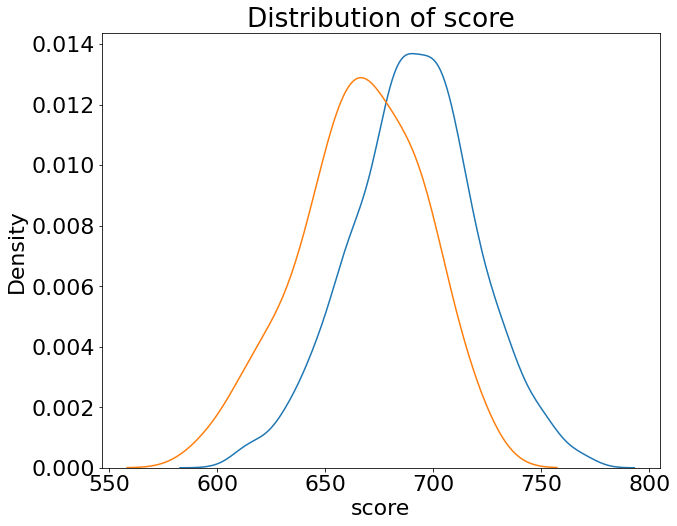

In [ ]:
import seaborn as sns
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(sc.loc[sc['target'] == 0, 'score'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(sc.loc[sc['target'] == 1, 'score'] , label = 'target == 1')

# Labeling of plot
plt.xlabel('score'); plt.ylabel('Density'); plt.title('Distribution of score');

**Aggregation Method**

In [ ]:
cash_lower_agg=agg_numeric(cash_lower, 'SK_ID_PREV',['SK_ID_CURR'],['mean','min','max','std','median'],'cash')
credit_lower_agg=agg_numeric(credit_lower, 'SK_ID_PREV',['SK_ID_CURR'],['mean','min','max','std','median'],'credit')


In [ ]:
cash_lower_agg.drop(columns='SK_ID_PREV',inplace=True)

credit_lower_agg.drop(columns='SK_ID_PREV',inplace=True)

In [ ]:
cash_lower_agg2=agg_numeric(cash_lower_agg, 'SK_ID_CURR',[],['mean'])
credit_lower_agg2=agg_numeric(credit_lower_agg, 'SK_ID_CURR',[],['mean'])


In [ ]:
app_train_low.reset_index(inplace=True,drop=True)
app_train_low

In [ ]:
result=app_train_low.merge(cash_lower_agg2, on='SK_ID_CURR')

In [ ]:
result2=result.merge(credit_lower_agg2,on='SK_ID_CURR')

In [ ]:
result2=result2.set_index('SK_ID_CURR')

In [ ]:
train=woe(result2,'TARGET')

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 7366 rows and 177 columns in 00:02:14
[INFO] converting into woe values ...


Removing collinear variables

In [ ]:
train=remove_collinear(train)

There are 61 columns to remove.


In [ ]:
train

,FLAG_DOCUMENT_21,FLAG_DOCUMENT_12,FLAG_DOCUMENT_17,FLAG_DOCUMENT_10,TARGET,_cash_SK_DPD_DEF_min_mean,FLAG_MOBIL,FLAG_DOCUMENT_7,_credit_SK_DPD_min_mean,_credit_AMT_TOTAL_RECEIVABLE_mean_mean_woe,_credit_AMT_DRAWINGS_CURRENT_median_mean_woe,DAYS_EMPLOYED_woe,_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean_woe,EXT_SOURCE_2_woe,NAME_TYPE_SUITE_woe,_cash_CNT_INSTALMENT_std_mean_woe,OBS_60_CNT_SOCIAL_CIRCLE_woe,FLAG_DOCUMENT_11_woe,_credit_AMT_PAYMENT_TOTAL_CURRENT_max_mean_woe,DAYS_LAST_PHONE_CHANGE_woe,NAME_HOUSING_TYPE_woe,_credit_SK_DPD_DEF_mean_mean_woe,_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean_woe,_cash_SK_DPD_DEF_std_mean_woe,_cash_SK_DPD_median_mean_woe,DAYS_REGISTRATION_woe,FLAG_DOCUMENT_3_woe,_credit_CNT_DRAWINGS_POS_CURRENT_mean_mean_woe,NAME_CONTRACT_TYPE_woe,DEF_60_CNT_SOCIAL_CIRCLE_woe,_credit_CNT_INSTALMENT_MATURE_CUM_max_mean_woe,FLAG_OWN_REALTY_woe,_credit_CNT_DRAWINGS_ATM_CURRENT_max_mean_woe,_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean_woe,REG_REGION_NOT_LIVE_REGION_woe,FLAG_PHONE_woe,REGION_RATING_CLIENT_W_CITY_woe,_cash_CNT_INSTALMENT_mean_mean_woe,_credit_SK_DPD_max_mean_woe,...,_credit_AMT_RECEIVABLE_PRINCIPAL_min_mean_woe,_credit_CNT_INSTALMENT_MATURE_CUM_min_mean_woe,_credit_AMT_PAYMENT_CURRENT_mean_mean_woe,LIVE_CITY_NOT_WORK_CITY_woe,_credit_CNT_DRAWINGS_CURRENT_mean_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_min_mean_woe,_credit_CNT_INSTALMENT_MATURE_CUM_median_mean_woe,_credit_AMT_INST_MIN_REGULARITY_std_mean_woe,FLAG_DOCUMENT_16_woe,AMT_ANNUITY_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_std_mean_woe,EXT_SOURCE_3_woe,REGION_POPULATION_RELATIVE_woe,FLAG_DOCUMENT_2_woe,AMT_REQ_CREDIT_BUREAU_MON_woe,AMT_REQ_CREDIT_BUREAU_QRT_woe,_credit_AMT_DRAWINGS_POS_CURRENT_max_mean_woe,_cash_CNT_INSTALMENT_min_mean_woe,_cash_CNT_INSTALMENT_FUTURE_min_mean_woe,LIVE_REGION_NOT_WORK_REGION_woe,ORGANIZATION_TYPE_woe,_credit_SK_DPD_DEF_median_mean_woe,FLAG_CONT_MOBILE_woe,_credit_CNT_DRAWINGS_CURRENT_min_mean_woe,_credit_CNT_INSTALMENT_MATURE_CUM_std_mean_woe,_credit_AMT_PAYMENT_CURRENT_median_mean_woe,_credit_CNT_INSTALMENT_MATURE_CUM_mean_mean_woe,AMT_INCOME_TOTAL_woe,DAYS_BIRTH_woe,REG_CITY_NOT_LIVE_CITY_woe,_cash_SK_DPD_DEF_mean_mean_woe,_credit_CNT_DRAWINGS_POS_CURRENT_median_mean_woe,_credit_CNT_DRAWINGS_CURRENT_std_mean_woe,_cash_CNT_INSTALMENT_FUTURE_mean_mean_woe,_cash_CNT_INSTALMENT_FUTURE_std_mean_woe,AMT_REQ_CREDIT_BUREAU_HOUR_woe,FLAG_DOCUMENT_4_woe,FLAG_DOCUMENT_14_woe,FLAG_DOCUMENT_15_woe,DAYS_ID_PUBLISH_woe
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100011,0,0,0,0,0,0,1,0,0,-0.043382,-0.050319,-0.270916,0.036569,0.096305,0.404417,0.127052,-0.053044,0.111153,0.0,0.107860,0.082246,-0.020169,-0.054764,-0.174210,0.329559,0.0,0.012648,0.022114,-0.051692,0.0,-0.016518,0.177104,-0.041234,0.141136,0.140555,0.0,0.077444,-0.038376,-0.022715,-0.079982,...,-0.012715,0.062956,-0.131450,-0.025433,-0.210833,0.124217,-0.005822,-0.084856,0.0,0.086782,0.047329,-0.713725,0.007673,0.0,-0.030762,0.024538,0.009552,0.029603,0.007386,0.0,-0.328393,0.0,0.0,0.0,-0.029924,-0.158421,-0.078757,-0.169323,0.001640,0.0,-0.04354,0.0,-0.242694,-0.017373,0.029931,0.0,0.0,0.0,0.0,-0.035442
100043,0,0,0,0,0,0,1,0,0,0.302747,-0.050319,0.310002,0.036569,-0.022856,-0.110554,0.012083,0.242715,-0.059239,0.0,0.421684,-0.283229,-0.020169,-0.054764,-0.174210,-0.108535,0.0,0.278210,0.022114,0.396913,0.0,-0.016518,-0.147200,-0.041234,-0.100482,0.034567,0.0,-0.213686,-0.038376,0.399644,-0.079982,...,-0.012715,0.062956,0.612138,-0.025433,0.208192,-0.013346,0.146721,0.434218,0.0,0.086782,-0.246284,-0.713725,0.007673,0.0,-0.030762,-0.267212,0.007822,0.203533,0.007386,0.0,0.148992,0.0,0.0,0.0,0.025269,-0.245848,0.150077,0.085848,0.001640,0.0,-0.04354,0.0,0.006594,0.388995,0.176092,0.0,0.0,0.0,0.0,-0.128882
100145,0,0,0,0,0,0,1,0,0,-0.287106,-0.050319,-0.022123,0.036569,-0.104523,-0.763592,-0.142254,-0.053044,0.004242,0.0,0.107860,-0.033890,-0.020169,-0.054764,-0.174210,-0.10853

In [ ]:
X = train.drop(['TARGET'], axis=1)
y = train.TARGET
feature_name = X.columns.tolist()


In [ ]:
feature_selection_df=summary(X,y,100,LogisticRegression())
feature_selection_df

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Expert,Total
1,_credit_CNT_INSTALMENT_MATURE_CUM_std_mean_woe,True,True,True,True,True,True,False,6
2,_credit_CNT_INSTALMENT_MATURE_CUM_max_mean_woe,True,True,True,True,True,True,False,6
3,_credit_CNT_DRAWINGS_CURRENT_max_mean_woe,True,True,True,True,True,True,False,6
4,_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean_woe,True,True,True,True,True,True,False,6
5,_credit_AMT_PAYMENT_TOTAL_CURRENT_mean_mean_woe,True,True,True,True,True,True,False,6
6,_credit_AMT_PAYMENT_TOTAL_CURRENT_max_mean_woe,True,True,True,True,True,True,False,6
7,_credit_AMT_PAYMENT_CURRENT_mean_mean_woe,True,True,True,True,True,True,False,6
8,_credit_AMT_INST_MIN_REGULARITY_std_mean_woe,True,True,True,True,True,True,False,6
9,_credit_AMT_CREDIT_LIMIT_ACTUAL_min_mean_woe,True,True,True,True,True,True,False,6
10,_cash_SK_DPD_DEF_std_mean_woe,True,True,True,True,True,True,False,6


In [ ]:
lista=feature_selection_df['Feature'].tolist()
train=train[lista]

In [ ]:
train

,_credit_CNT_INSTALMENT_MATURE_CUM_std_mean_woe,_credit_CNT_INSTALMENT_MATURE_CUM_max_mean_woe,_credit_CNT_DRAWINGS_CURRENT_max_mean_woe,_credit_CNT_DRAWINGS_ATM_CURRENT_mean_mean_woe,_credit_AMT_PAYMENT_TOTAL_CURRENT_mean_mean_woe,_credit_AMT_PAYMENT_TOTAL_CURRENT_max_mean_woe,_credit_AMT_PAYMENT_CURRENT_mean_mean_woe,_credit_AMT_INST_MIN_REGULARITY_std_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_min_mean_woe,_cash_SK_DPD_DEF_std_mean_woe,_cash_CNT_INSTALMENT_min_mean_woe,_cash_CNT_INSTALMENT_FUTURE_mean_mean_woe,REGION_RATING_CLIENT_W_CITY_woe,ORGANIZATION_TYPE_woe,EXT_SOURCE_3_woe,EXT_SOURCE_2_woe,DAYS_REGISTRATION_woe,DAYS_LAST_PHONE_CHANGE_woe,DAYS_BIRTH_woe,AMT_GOODS_PRICE_woe,AMT_ANNUITY_woe,_credit_CNT_INSTALMENT_MATURE_CUM_mean_mean_woe,_credit_CNT_DRAWINGS_CURRENT_std_mean_woe,_credit_AMT_TOTAL_RECEIVABLE_min_mean_woe,_credit_AMT_TOTAL_RECEIVABLE_mean_mean_woe,_credit_AMT_DRAWINGS_POS_CURRENT_std_mean_woe,_credit_AMT_DRAWINGS_ATM_CURRENT_mean_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_std_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_mean_mean_woe,_cash_CNT_INSTALMENT_mean_mean_woe,_cash_CNT_INSTALMENT_FUTURE_min_mean_woe,CODE_GENDER_woe,AMT_REQ_CREDIT_BUREAU_YEAR_woe,AMT_CREDIT_woe,_credit_SK_DPD_DEF_mean_mean_woe,_credit_CNT_DRAWINGS_ATM_CURRENT_max_mean_woe,_credit_AMT_PAYMENT_TOTAL_CURRENT_median_mean_woe,_credit_AMT_PAYMENT_CURRENT_median_mean_woe,_credit_AMT_DRAWINGS_POS_CURRENT_max_mean_woe,_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_mean_woe,_credit_AMT_CREDIT_LIMIT_ACTUAL_median_mean_woe,_cash_CNT_INSTALMENT_std_mean_woe,_cash_CNT_INSTALMENT_median_mean_woe,WEEKDAY_APPR_PROCESS_START_woe,OBS_60_CNT_SOCIAL_CIRCLE_woe,NAME_INCOME_TYPE_woe,NAME_FAMILY_STATUS_woe,NAME_EDUCATION_TYPE_woe,HOUR_APPR_PROCESS_START_woe,DAYS_ID_PUBLISH_woe,DAYS_EMPLOYED_woe,AMT_INCOME_TOTAL_woe
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100011,-0.029924,0.177104,0.131465,-0.174210,-0.029048,0.107860,-0.131450,-0.084856,0.124217,0.329559,0.029603,-0.017373,-0.038376,-0.328393,-0.713725,0.404417,0.012648,0.082246,0.001640,-0.353954,0.086782,-0.078757,-0.242694,-0.096428,-0.043382,-0.117547,-0.159323,0.047329,0.096305,-0.022715,0.007386,-0.131509,-0.029850,-0.479826,-0.054764,0.141136,-0.162342,-0.158421,0.009552,0.036569,-0.057680,-0.053044,-0.018489,0.148741,0.111153,-0.338591,-0.019851,0.074382,0.050534,-0.035442,-0.270916,-0.169323
100043,0.025269,-0.147200,0.316235,-0.174210,0.310148,0.421684,0.612138,0.434218,-0.013346,-0.108535,0.203533,0.388995,-0.038376,0.148992,-0.713725,-0.110554,0.278210,-0.283229,0.001640,0.390619,0.086782,0.150077,0.006594,0.022128,0.302747,0.125052,-0.159323,-0.246284,-0.022856,0.399644,0.007386,-0.131509,-0.029850,0.111904,-0.054764,-0.100482,-0.162342,-0.245848,0.007822,0.036569,0.187122,0.242715,0.375449,-0.051099,-0.059239,-0.068081,-0.019851,0.074382,0.050534,-0.128882,0.310002,0.085848
100145,-0.176020,0.413287,-0.231411,-0.174210,-0.326471,0.107860,-0.263365,0.064320,-0.170625,-0.108535,-0.113856,0.388995,-0.038376,0.148992,-0.713725,-0.763592,0.278210,-0.033890,0.241295,0.005272,0.086782,0.150077,-0.242694,-0.640849,-0.287106,-0.117547,-0.159323,0.047329,-0.104523,-0.024831,0.326374,-0.131509,-0.072410,0.111904,-0.054764,-0.302824,-0.162342,-0.158421,0.009552,0.036569,-0.142868,-0.053044,0.070005,0.077220,0.004242,0.169348,-0.074138,0.074382,0.050534,0.290808,-0.022123,0.085848
100153,-0.254752,-0.505359,0.316235,0.279503,0.086882,-0.517055,-0.131450,-0.084856,0.124217,-0.108535,0.203533,0.097840,-0.038376,0.148992,0.505689,-0.110554,-0.273397,-0.033890,0.001640,-0.353954,0.086782,-0.493525,0.455482,0.022128,-0.043382,-0.440179,-0.287610,-0.049043,-0.073067,-0.024831,0.007386,0.287175,0.242182,-0.479826,0.228345,0.348301,0.045830,0.095896,0.173844,0.036569,0.007731,0.317405,-0.084293,-0.191738,-0.059239,0.169348,-0.019851,0.074382,0.050534,-0.239291,0.067017,0.085848
100181,-0.029924,-0.147200,-0.231411,-0.174210,-0.326471,-0.310523,-0.131450,-0.193201,-0.013346,-0.108535,0.029603,-0.017373,-

Modeling

In [ ]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X=train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5892, 52) (1474, 52) (5892,) (1474,)


In [ ]:
y_pred1=Logistic_Regression (X_train, X_test, y_train)
y_pred1

array([[0.94818144, 0.05181856],
       [0.98075326, 0.01924674],
       [0.96345748, 0.03654252],
       ...,
       [0.96820524, 0.03179476],
       [0.988246  , 0.011754  ],
       [0.97528497, 0.02471503]])

In [ ]:
y_pred2=Random_Forest (X_train, X_test, y_train)
y_pred2

array([[0.91, 0.09],
       [0.96, 0.04],
       [0.96, 0.04],
       ...,
       [0.95, 0.05],
       [1.  , 0.  ],
       [0.92, 0.08]])

In [ ]:
y_pred3=XGB_Classifier (X_train,y_train, X_test)
y_pred3

array([[0.94668585, 0.05331414],
       [0.9637967 , 0.03620332],
       [0.96305823, 0.0369418 ],
       ...,
       [0.9693886 , 0.03061141],
       [0.98560435, 0.01439563],
       [0.9767676 , 0.0232324 ]], dtype=float32)

In [ ]:
y_pred4=light_gbm (X_train,y_train, X_test)
y_pred4

array([[0.95749999, 0.04250001],
       [0.98031323, 0.01968677],
       [0.95692776, 0.04307224],
       ...,
       [0.96980294, 0.03019706],
       [0.99447135, 0.00552865],
       [0.99426338, 0.00573662]])

In [ ]:

y_pred5=neural_network_MLP (X_train,y_train, X_test)
y_pred5

array([[9.79304228e-01, 2.06957724e-02],
       [9.45094432e-01, 5.49055676e-02],
       [9.99438286e-01, 5.61714220e-04],
       ...,
       [9.91754073e-01, 8.24592736e-03],
       [9.99903947e-01, 9.60527475e-05],
       [9.99254729e-01, 7.45270505e-04]])

In [ ]:

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred1[:,1]>0.5))

In [ ]:

def scoring (offset,factor,y_pred,y_test,X_test) :
  """
  uses te probability of each target variable to transform it into a score 
  using the formula below

  PARAMETERS:
  ------------
  offset :the starting value of the score
  factor : the manner by which the score scales
  y_pred : the probabilities of each row predicted of the target
  X_test : the test dataset 
  key : the key of the test dataset  
  RETURNS :
  -------------
  returns the scores of the predicted probabilities for each variable
  """
  score=offset+factor*np.log(y_pred[:,0]/y_pred[:,1])
  scorecard = pd.DataFrame(columns=['score','target'],index=X_test.index)
  scorecard['score']=score
  scorecard['target']=y_test.tolist()



  
  return scorecard

In [ ]:
sc=scoring(600,30,y_pred1,y_test,X_test)
sc

,score,target
SK_ID_CURR,,
277869,687.203922,0
385334,717.929374,0
267227,698.161556,0
145179,716.838161,0
121465,673.619503,0
...,...,...
100181,667.586791,1
118545,684.723988,0
446835,702.484275,0


In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score_reg = roc_auc_score(y_test, y_pred1[:,1])
auc_score_rf = roc_auc_score(y_test,  y_pred2[:,1])
auc_score_XGB = roc_auc_score(y_test, y_pred3[:,1])
auc_score_lgbm = roc_auc_score(y_test,  y_pred4[:,1])
auc_score_MLP = roc_auc_score(y_test, y_pred5[:,1])


print(auc_score_reg, auc_score_rf,auc_score_XGB,auc_score_lgbm,auc_score_MLP)

0.7006244218316373 0.6386062288004932 0.6897702744372495 0.6533610854147394 0.6571461609620722


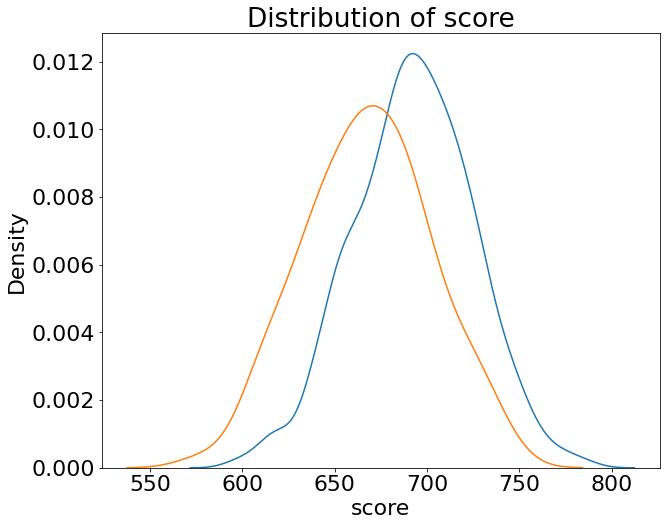

In [ ]:
import seaborn as sns
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(sc.loc[sc['target'] == 0, 'score'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(sc.loc[sc['target'] == 1, 'score'] , label = 'target == 1')

# Labeling of plot
plt.xlabel('score'); plt.ylabel('Density'); plt.title('Distribution of score');

# Nouvelle section